# Chapter 7 : Grouping for Aggregation, Filtration and Transformation

## Recipes
* [7.1 Defining an aggregation](#7.1-Defining-an-aggregation)
* [7.2 Grouping and aggregating with multiple columns and functions](#7.2-Grouping-and-aggregating-with-multiple-columns-and-functions)
* [7.3 Removing the MultiIndex after grouping](#7.3-Removing-the-MultiIndex-after-grouping)
* [7.4 Customizing an aggregation function](#7.4-Customizing-an-aggregation-function)
* [7.5 Customizing aggregating functions with kwargs and args](#7.5-Customizing-aggregating-functions-with-kwargs-and-args)
* [7.6 Examining a groupby object](#7.6-Examining-a-groupby-object)
* [7.7 Filtering for states with minimum](#7.7-Filtering-for-states-with-minimum)
* [7.8 Transforming through a weight-loss](#7.8-Transforming-through-a-weight-loss)
* [7.9 Calculating weighted mean SAT scores per state with apply](#7.9-Calculating-weighted-mean-SAT-scores-per-state-with-apply)
* [7.10 Grouping by continuous variables](#7.10-Grouping-by-continuous-variables)
* [7.11 Counting the total number of flights between cities](#7.11-Counting-the-total-number-of-flights-between-cities)
* [7.12 Finding the longest streak of on-time flights](#7.12-Finding-the-longest-streak-of-on-time-flights)

In [1]:
import pandas as pd
import numpy as np

# 7.1 Defining an aggregation

In [2]:
### [Tech] 그룹화 후 집계 연산을 수행해 본다. 
#       aggregating columns :  .groupby(['grouping','columns'])  
#       aggregating functions : 
#            pattern 1 using dictionary : .agg({'집계컬럼' : '집계함수',})
#            pattern 2 
### [Goal] 항공사 별 평균 연착시간 구하기

## >> How to do it...

In [3]:
#7.1.1  fligths.csv로 부터 flights 를 load 한다 
flights = pd.read_csv('data/flights.csv')
flights.head()

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
4,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0


In [4]:
# 총 58492 건
# 일자 정보 : MONTH, DAY, WEEKDAY
# 항공사/공항정보 : AIRLINE, ORG_AIR, DEST_AIR
# 기록 정보 : SCHED_DEP, DEP_DELAY, AIR_TIME, DIST, SCHED_ARR, 
#            ARR_DELAY, DIVERTED, CANCELLED
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58492 entries, 0 to 58491
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MONTH      58492 non-null  int64  
 1   DAY        58492 non-null  int64  
 2   WEEKDAY    58492 non-null  int64  
 3   AIRLINE    58492 non-null  object 
 4   ORG_AIR    58492 non-null  object 
 5   DEST_AIR   58492 non-null  object 
 6   SCHED_DEP  58492 non-null  int64  
 7   DEP_DELAY  57659 non-null  float64
 8   AIR_TIME   57474 non-null  float64
 9   DIST       58492 non-null  int64  
 10  SCHED_ARR  58492 non-null  int64  
 11  ARR_DELAY  57474 non-null  float64
 12  DIVERTED   58492 non-null  int64  
 13  CANCELLED  58492 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 6.2+ MB


In [5]:
# DIVERTED 우회/CANCELLED 취소 는 여부를 나타내는 binary column
flights.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTH,58492.0,6.220646,3.358484,1.0,3.0,6.0,9.0,12.0
DAY,58492.0,15.702096,8.760846,1.0,8.0,16.0,23.0,31.0
WEEKDAY,58492.0,3.926862,1.995777,1.0,2.0,4.0,6.0,7.0
SCHED_DEP,58492.0,1387.984836,482.810792,5.0,1000.0,1353.0,1805.0,2359.0
DEP_DELAY,57659.0,10.921192,36.146210,-24.0,-4.0,-1.0,10.0,1194.0
AIR_TIME,57474.0,115.928576,71.679591,8.0,61.0,97.0,152.0,577.0
DIST,58492.0,872.900072,624.996805,67.0,391.0,690.0,1199.0,4502.0
SCHED_ARR,58492.0,1549.399832,518.599952,1.0,1159.0,1603.0,1959.0,2359.0
ARR_DELAY,57474.0,5.812315,38.411948,-60.0,-12.0,-4.0,9.0,1185.0
DIVERTED,58492.0,0.002342,0.048340,0.0,0.0,0.0,0.0,1.0


In [6]:
flights[['DIVERTED', 'CANCELLED']].nunique()

DIVERTED     2
CANCELLED    2
dtype: int64

In [7]:
# 14개 항공사, 10개 출발 공항, 271개 도착공항
flights.describe(include = 'object').T

,count,unique,top,freq
AIRLINE,58492,14,DL,10601
ORG_AIR,58492,10,ATL,10413
DEST_AIR,58492,271,LAX,1991


In [8]:
# 7.1.2 항공사별로 도착 지연시간의 평균을 구한다. 
#   pattern 1 :  사전dictionary에  집계 컬럼과 집계 함수의 쌍을 전달 
flights.groupby('AIRLINE').agg({'ARR_DELAY':'mean'}).head()

,ARR_DELAY
AIRLINE,
AA,5.542661
AS,-0.833333
B6,8.692593
DL,0.339691
EV,7.034580


In [9]:
# 7.1.3 pattern 2 : 집계 컬럼은 인덱스 연산자로 선택하고, .agg()의 인자로 집계함수 전달
#    집계함수를 문자열로 표현
flights.groupby('AIRLINE')['ARR_DELAY'].agg('mean').head()

AIRLINE
AA    5.542661
AS   -0.833333
B6    8.692593
DL    0.339691
EV    7.034580
Name: ARR_DELAY, dtype: float64

In [10]:
# 7.1.4 pattern 2 :  집계 컬럼은 인덱스 연산자로 선택하고, .agg()의 인자로 집계함수 전달
#   집계 함수를 NumPy 객체로 표현
flights.groupby('AIRLINE')['ARR_DELAY'].agg(np.mean).head()

AIRLINE
AA    5.542661
AS   -0.833333
B6    8.692593
DL    0.339691
EV    7.034580
Name: ARR_DELAY, dtype: float64

In [11]:
# 7.1.5 pattern 3 : 집계컬럼은 인덱스 연산자로 선택, 
#                  집계함수는  .agg()메소드 없이 직접 집계함수 연계
flights.groupby('AIRLINE')['ARR_DELAY'].mean().head()

AIRLINE
AA    5.542661
AS   -0.833333
B6    8.692593
DL    0.339691
EV    7.034580
Name: ARR_DELAY, dtype: float64

In [12]:
dir(flights.groupby('AIRLINE'))

['AIRLINE',
 'AIR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'DAY',
 'DEP_DELAY',
 'DEST_AIR',
 'DIST',
 'DIVERTED',
 'MONTH',
 'ORG_AIR',
 'SCHED_ARR',
 'SCHED_DEP',
 'WEEKDAY',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_examples_doc',
 '_agg_see_also_doc',
 '_aggregate',
 '_aggregate_frame',
 '_aggregate_item_by_item',
 '_aggregate_multiple_funcs',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_bool_agg',
 '_builtin_table',
 '_choose_path',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_c

## >> How it works...

In [13]:
# groupby 객체는 다음작업을 위해서  분류를 준비한 상태의 객체이다. 
#  아래 grouped 의 경우,  항공사별로 어떠한 작업을 하기 위해 준비된 객체이다.
grouped = flights.groupby('AIRLINE')
type(grouped)

pandas.core.groupby.generic.DataFrameGroupBy

## >> There's more... 7.1

In [14]:
# 집계함수는 수행 결과 하나의 scala 값으로 변환 되어야 한다. 
# 즉 그룹별로 하나의 값으로 집계 되어야 한다. 
# np.sqrt 와 같이 각 값을 제곱해서 원래의 차원을 유지하는 연산은 처리 할 수 없다. 
flights.groupby('AIRLINE')['ARR_DELAY'].agg(np.sqrt)

C:\Users\jenni\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Must produce aggregated value

# 7.2 Grouping and aggregating with multiple columns and functions

In [15]:
### [Tech] 복수개 컬럼/집계함수를 이용한 집계 수행
#          복수개의 grouping columns  (분류 컬럼)
#          복수개의 aggregation columns (집계 컬럼)
#          복수개의 aggregation functions (집계 함수)
### [Goal] 항공사별 다양한 집계치를 산정해본다. 

## >> How to do it...

In [16]:
# 7.2.1  fligths.csv로 부터 flights 를 load 한다 
flights = pd.read_csv('data/flights.csv')
# 항공사별 요일별 취소 항공 건수  (복수개 분류컬럼 grouping)
flights.groupby(['AIRLINE', 'WEEKDAY'])['CANCELLED'].agg('sum').head(7)

AIRLINE  WEEKDAY
AA       1          41
         2           9
         3          16
         4          20
         5          18
         6          21
         7          29
Name: CANCELLED, dtype: int64

In [17]:
# 7.2.2 항공사별 요일별 취소  항공 건수 및 평균 우회 비율 
# (복수개 집계 컬럼과 집계 함수 )
flights.groupby(['AIRLINE', 'WEEKDAY'])\
    [['CANCELLED', 'DIVERTED']].agg(['sum', 'mean']).head(7)

CANCELLED           DIVERTED          
                      sum      mean      sum      mean
AIRLINE WEEKDAY                                       
AA      1              41  0.032106        6  0.004699
        2               9  0.007341        2  0.001631
        3              16  0.011949        2  0.001494
        4              20  0.015004        5  0.003751
        5              18  0.014151        1  0.000786
        6              21  0.018667        9  0.008000
        7              29  0.021837        1  0.000753

In [18]:
# 7.2.3 출발공항-도착공항 별 취소 항공수 집계(합계 평균 건수) 및 비행시간 집계 (평균, 분산)
# 사전에 원하는 원하는 집계 컬럼별로 집계 함수를 지정해서 집계를 수행 할 수 있다. 
group_cols = ['ORG_AIR', 'DEST_AIR']
agg_dict = {'CANCELLED': ['sum', 'mean', 'size'], 
             'AIR_TIME':['mean', 'var']}
flights.groupby(group_cols).agg(agg_dict).head()

CANCELLED              AIR_TIME           
                       sum mean size        mean        var
ORG_AIR DEST_AIR                                           
ATL     ABE              0  0.0   31   96.387097  45.778495
        ABQ              0  0.0   16  170.500000  87.866667
        ABY              0  0.0   19   28.578947   6.590643
        ACY              0  0.0    6   91.333333  11.466667
        AEX              0  0.0   40   78.725000  47.332692

In [19]:
#  groupby 를 이용한 집계 적용 패턴

"""
1. 사전 : 가장 유연한 지정이 가능
   df.groupby(['grouping col1','col2'])\
           .agg ({'agg cols1' : ['agg','funcs'],
                  'agg cols2' :['agg','funcs2'],})

2. 인덱스 연산자 + .agg()  : 모든 컬럼에 동일한 집계 함수 적용시 (집계컬럼 x 집계함수)
   df.groupby(['grouping col1','col2'])\
           [['agg col1', 'agg col2',]]\
           .agg([agg func1, func2,])

3. 인덱스 연산자 + .집계함수 : 다양한 컬럼에 대해서 하나의 집계 함수 적용시 
   df.groupby(['grouping col1','col2'])\
           [['agg col1', 'agg col2',]]\
           .aggfunc()

4. 집계함수 : 그룹화에 사용되지 않은 모든 컬럼에 대해 동일한 집계 함수 적용
   df.groupby(['grouping col1','col2'])\
           .aggfunc()

"""
''

''

# 7.3 Removing the MultiIndex after grouping

In [20]:
### [Tech] 계층화된 Index를 1차원 단일 인덱스로 변환한다. 
### [Goal] 항공사별 주별 총운항거리, 평균운항거리, 최소지연, 최대지연

## >> How to do it...

In [21]:
# 7.3.1 fligths.csv로 부터 flights 를 load 한다 
flights = pd.read_csv('data/flights.csv')
flights.head()

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
4,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0


In [22]:
# 항공사별 요일별, 비행거리 합계/평균, 지연시간의 최소 최대값을 구한다. 
airline_info = flights.groupby(['AIRLINE', 'WEEKDAY'])\
                      .agg({'DIST':['sum', 'mean'], 
                            'ARR_DELAY':['min', 'max']})\
                      .astype(int)
airline_info.head()

DIST       ARR_DELAY     
                     sum  mean       min  max
AIRLINE WEEKDAY                              
AA      1        1455386  1139       -60  551
        2        1358256  1107       -52  725
        3        1496665  1117       -45  473
        4        1452394  1089       -46  349
        5        1427749  1122       -41  732

In [23]:
# 7.3.2 계층화 된 인덱스에 각 레벨별 값을 살펴 본다.
# 상위(바깥쪽, 0번) 에 집계 칼럼, 하위(안쪽, 1번)에 집계함수가 나타난다.  
# 컬럼의 level 0 의 값은 DIST DIST ARR_DELAY ARR_DELAY로 나타난다. 
level0 = airline_info.columns.get_level_values(0)
level0

Index(['DIST', 'DIST', 'ARR_DELAY', 'ARR_DELAY'], dtype='object')

In [24]:
# 컬럼의 level1 의 값은 sum mean min max가 된다. 
level1 = airline_info.columns.get_level_values(1)
level1

Index(['sum', 'mean', 'min', 'max'], dtype='object')

In [25]:
airline_info.columns

MultiIndex([(     'DIST',  'sum'),
            (     'DIST', 'mean'),
            ('ARR_DELAY',  'min'),
            ('ARR_DELAY',  'max')],
           )

In [26]:
# 한 줄로 변환하기 위해서 level0 와 level1의 각 위치를
# 연계한 새로운 컬럼명을 설정한다. 
airline_info.columns = level0 + '_' + level1
airline_info.head(7)

DIST_sum  DIST_mean  ARR_DELAY_min  ARR_DELAY_max
AIRLINE WEEKDAY                                                   
AA      1         1455386       1139            -60            551
        2         1358256       1107            -52            725
        3         1496665       1117            -45            473
        4         1452394       1089            -46            349
        5         1427749       1122            -41            732
        6         1265340       1124            -50            858
        7         1461906       1100            -49            626

In [27]:
# 7.3.3  
#기존의 인덱스를 해제하고 RangeIndex 형태로 reset 한다. 
airline_info.reset_index().head(7)

,AIRLINE,WEEKDAY,DIST_sum,DIST_mean,ARR_DELAY_min,ARR_DELAY_max
0,AA,1,1455386,1139,-60,551
1,AA,2,1358256,1107,-52,725
2,AA,3,1496665,1117,-45,473
3,AA,4,1452394,1089,-46,349
4,AA,5,1427749,1122,-41,732
5,AA,6,1265340,1124,-50,858
6,AA,7,1461906,1100,-49,626


## >> There's more... 7.3

In [28]:
flights.groupby(['AIRLINE'])['DIST'].agg('mean').round(0)

AIRLINE
AA    1114.0
AS    1066.0
B6    1772.0
DL     866.0
EV     460.0
F9     970.0
HA    2615.0
MQ     404.0
NK    1047.0
OO     511.0
UA    1231.0
US    1181.0
VX    1240.0
WN     810.0
Name: DIST, dtype: float64

In [29]:
# groupby 시에  as_index = False를 설정하면 인덱스가 해제된 결과물을 반환한다. 
flights.groupby(['AIRLINE'], as_index=False)['DIST'].agg('mean').round(0)

,AIRLINE,DIST
0,AA,1114.0
1,AS,1066.0
2,B6,1772.0
3,DL,866.0
4,EV,460.0
5,F9,970.0
6,HA,2615.0
7,MQ,404.0
8,NK,1047.0
9,OO,511.0


In [30]:
# 정렬 sort 는 기본값이 True인데, False로 설정하면 약간의 성능 향상이 기대 된다. 
flights.groupby(['AIRLINE'], as_index=False, sort=False)['DIST'].agg('mean')

,AIRLINE,DIST
0,WN,809.985626
1,UA,1230.918891
2,MQ,404.229041
3,AA,1114.347865
4,F9,969.593014
5,EV,460.237453
6,OO,511.239375
7,NK,1047.428100
8,US,1181.226625
9,AS,1065.884115


# 7.4 Customizing an aggregation function

In [31]:
### [Tech] 사용자가 직접 생성한 집계 함수를 groupby의 집계 함수로 사용할 수 있다. 
###        이 때 return 되는 값은 scala 여야 한다. 
### [Goal] college에서  주State 별 최대 표준편차값을 구해보자. 

## >> How to do it...

In [32]:
# 7.4.1  college.csv로 부터 college를 load 한다. 
#       주state별로 학부생수의 평균과 편차를 구한다. 
college = pd.read_csv('data/college.csv')
college.groupby('STABBR')['UGDS'].agg(['mean', 'std']).round(0).head()

,mean,std
STABBR,,
AK,2493.0,4052.0
AL,2790.0,4658.0
AR,1644.0,3143.0
AS,1276.0,NaN
AZ,4130.0,14894.0


In [33]:
# 7.4.2 
# 그룹내에서 최고의 표준편차 값을 구하는 함수를 생성한다. 
#     입력값이 Series이고 반환은 scala 이다. 
def max_deviation(s):
    std_score = (s - s.mean()) / s.std()
    return std_score.abs().max()

In [34]:
s = college['UGDS']
std_score = (s - s.mean()) / s.std()
std_score.abs().max()

27.254958570928967

In [35]:
# 7.4.3 
# 집계 함수로 사용자가 작성한 max_divation을 전달한다.
college.groupby('STABBR')['UGDS'].agg(max_deviation)\
    .round(1).head()

STABBR
AK    2.6
AL    5.8
AR    6.3
AS    NaN
AZ    9.9
Name: UGDS, dtype: float64

## >> There's more... 7.4

In [36]:
# 복수개의 집계컬럼에 대해서도 동일 요령으로 적용 가능하다. 
college.groupby('STABBR')['UGDS', 'SATVRMID', 'SATMTMID']\
        .agg(max_deviation).round(1).head()

<ipython-input-36-b0baf6b0e6db>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  college.groupby('STABBR')['UGDS', 'SATVRMID', 'SATMTMID']\


,UGDS,SATVRMID,SATMTMID
STABBR,,,
AK,2.6,NaN,NaN
AL,5.8,1.6,1.8
AR,6.3,2.2,2.3
AS,NaN,NaN,NaN
AZ,9.9,1.9,1.4


In [37]:
# 복수개의 집계 함수를 지정하고자 할 때, 기본 제공되는 함수들과 함께 사용할 수 있다.
college.groupby(['STABBR', 'RELAFFIL'])['UGDS', 'SATVRMID', 'SATMTMID']\
       .agg([max_deviation, 'mean', 'std']).round(1).head()

<ipython-input-37-137f2e9159b8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  college.groupby(['STABBR', 'RELAFFIL'])['UGDS', 'SATVRMID', 'SATMTMID']\


UGDS                      SATVRMID               \
                max_deviation    mean     std max_deviation   mean   std   
STABBR RELAFFIL                                                            
AK     0                  2.1  3508.9  4539.5           NaN    NaN   NaN   
       1                  1.1   123.3   132.9           NaN  555.0   NaN   
AL     0                  5.2  3248.8  5102.4           1.6  514.9  56.5   
       1                  2.4   979.7   870.8           1.5  498.0  53.0   
AR     0                  5.8  1793.7  3401.6           1.9  481.1  37.9   

                     SATMTMID               
                max_deviation   mean   std  
STABBR RELAFFIL                             
AK     0                  NaN    NaN   NaN  
       1                  NaN  503.0   NaN  
AL     0                  1.7  515.8  56.7  
       1                  1.4  485.6  61.4  
AR     0                  2.0  503.6  39.0

In [38]:
# 이 때 생성되는 컬럼명은  해당 함수의 __name__ 속성의 값으로 표기된다. 
# 별도 지정이 없다면, 함수명이 __name__이다. 
max_deviation.__name__

'max_deviation'

In [39]:
#  함수의 이름을 'Max Dev'로 지정한다. 
max_deviation.__name__ = 'Max Dev'

In [40]:
# 다시 동일한 연산을 수행하면 컬럼명이 새로 지정한 Max Dev로 출력된다. 
college.groupby(['STABBR', 'RELAFFIL'])['UGDS', 'SATVRMID', 'SATMTMID']\
       .agg([max_deviation, 'mean', 'std']).round(1).head()

<ipython-input-40-469e1e98bd1b>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  college.groupby(['STABBR', 'RELAFFIL'])['UGDS', 'SATVRMID', 'SATMTMID']\


UGDS                 SATVRMID              SATMTMID         \
                Max Dev    mean     std  Max Dev   mean   std  Max Dev   mean   
STABBR RELAFFIL                                                                 
AK     0            2.1  3508.9  4539.5      NaN    NaN   NaN      NaN    NaN   
       1            1.1   123.3   132.9      NaN  555.0   NaN      NaN  503.0   
AL     0            5.2  3248.8  5102.4      1.6  514.9  56.5      1.7  515.8   
       1            2.4   979.7   870.8      1.5  498.0  53.0      1.4  485.6   
AR     0            5.8  1793.7  3401.6      1.9  481.1  37.9      2.0  503.6   

                       
                  std  
STABBR RELAFFIL        
AK     0          NaN  
       1          NaN  
AL     0         56.7  
       1         61.4  
AR     0         39.0

# 7.5 Customizing aggregating functions with kwargs and args

In [41]:
### [Tech] 사용자 정의 집계 함수에, 추가적인 매개변수를 지정하고자 할 때, 
#          *args, **kwargs를 활용한다. 
### [Goal] college에서 주state 별 종교별 학부생중 특정 범위 인원을 갖는 비율 

In [42]:
# college.csv로 부터 college를 load 한다. 
# 주별, 종교기반 여부별 groupby 객체를 생성한다. 
college = pd.read_csv('data/college.csv')
grouped = college.groupby(['STABBR', 'RELAFFIL'])

In [43]:
# groupby 객체에 적용하는 agg 메소드의 signature (매개변수 정의)를 살펴보면
# *args와 **kwargs가 포함되어 있음을 알 수 있다. 
import inspect
inspect.signature(grouped.agg)

<Signature (func=None, *args, **kwargs)>

In [44]:
grouped.agg?

## >> How to do it...

In [45]:
# 7.5.1 예시를 위해, 사용자 정의 함수를 작성해본다. 
#      입력된 집계컬럼의 값 중 1000~ 3000 사이의 값을 갖는 비중 (불리언의 평균값)을 구한다. 
def pct_between_1_3k(s):
    return s.between(1000, 3000).mean()

In [46]:
# 7.5.2 주별, 종교기반 여부별 학생 수가 1000~ 3000명 사이인 학교 비중을 구하기 위해, 
#    사용자 정의 함수 pct_between_1_3를 집계함수 인자로 전달한다. 

college.groupby(['STABBR', 'RELAFFIL'])['UGDS']\
    .agg(pct_between_1_3k).head(9)

STABBR  RELAFFIL
AK      0           0.142857
        1           0.000000
AL      0           0.236111
        1           0.333333
AR      0           0.279412
        1           0.111111
AS      0           1.000000
AZ      0           0.096774
        1           0.000000
Name: UGDS, dtype: float64

In [47]:
# 7.5.3 이번에는 구하고자 하는 학생인원 범위의 상한 하한을 인수로 받는 함수를 정의한다. 
#     범용화된 형태
def pct_between(s, low, high):
    return s.between(low, high).mean()

In [48]:
# 7.5.4 .agg 로 집계함수를 호출 할 때에, 사용자 함수의 인자에 해당하는 low, high 값도 
#    함수명에 이어서 전달하면, 집계함수 인자 값으로 전달 된다. 
college.groupby(['STABBR', 'RELAFFIL'])['UGDS']\
    .agg(pct_between, 1000, 10000).head(9)

STABBR  RELAFFIL
AK      0           0.428571
        1           0.000000
AL      0           0.458333
        1           0.375000
AR      0           0.397059
        1           0.166667
AS      0           1.000000
AZ      0           0.233871
        1           0.111111
Name: UGDS, dtype: float64

## >> How it works...

In [49]:
# 모두 keyword args로 전달 할 경우 (즉 매개변수명을 지정하여 호출 할 경우),
# 전달 되는 인자의 순서는 변경된도 상관 없다. 
college.groupby(['STABBR', 'RELAFFIL'])['UGDS']\
    .agg(pct_between, high=10000, low=1000).head(9)

STABBR  RELAFFIL
AK      0           0.428571
        1           0.000000
AL      0           0.458333
        1           0.375000
AR      0           0.397059
        1           0.166667
AS      0           1.000000
AZ      0           0.233871
        1           0.111111
Name: UGDS, dtype: float64

In [50]:
# 위치 인자와 키워드 인자를 혼용할 수 있다. 
college.groupby(['STABBR', 'RELAFFIL'])['UGDS']\
    .agg(pct_between, 1000, high=10000).head(9)

STABBR  RELAFFIL
AK      0           0.428571
        1           0.000000
AL      0           0.458333
        1           0.375000
AR      0           0.397059
        1           0.166667
AS      0           1.000000
AZ      0           0.233871
        1           0.111111
Name: UGDS, dtype: float64

## >> There's more... 7.5

In [51]:
# 하지만, .agg 메소드에 복수 개의 집계함수를 입력할 경우에는 사용자 정의 함수에 
# 매개변수를 전달할 방법이 마땅치 않다. 
college.groupby(['STABBR', 'RELAFFIL'])['UGDS']\
    .agg(['mean', pct_between], low=100, high=1000)

TypeError: pct_between() missing 2 required positional arguments: 'low' and 'high'

In [52]:
# 이때는 파이썬의 closure 형태의 정의 (함수의 중첩) 를 사용해야 한다. 
# make_agg_func 라는 clousere 함수를 정의
def make_agg_func(func, name, *args, **kwargs):
    def wrapper(x):
        return func(x, *args, **kwargs)
    wrapper.__name__ = name
    return wrapper

# pct_between에 매개변수까지 전달한 wrapper 함수, my_agg1, my_agg2를 정의한다. 
my_agg1 = make_agg_func(pct_between, 'pct_1_3k', low=1000, high=3000)
my_agg2 = make_agg_func(pct_between, 'pct_10_30k', 10000, 30000)

In [53]:
# my_agg1, my_agg2를 사용하여 집계함수를 호출한다. 
college.groupby(['STABBR', 'RELAFFIL'])['UGDS']\
    .agg(['mean', my_agg1, my_agg2]).head()

mean  pct_1_3k  pct_10_30k
STABBR RELAFFIL                                   
AK     0         3508.857143  0.142857    0.142857
       1          123.333333  0.000000    0.000000
AL     0         3248.774648  0.236111    0.083333
       1          979.722222  0.333333    0.000000
AR     0         1793.691176  0.279412    0.014706

# 7.6 Examining a groupby object

In [54]:
### [Tech] .ngroups, .group , .get_group(), .nth()  - iterable with (key, item)
### [Goal] 그룹 객체가 갖는 메소드와 iterable 한 특성을 살펴 본다. 

## >> How to do it...

In [55]:
# 7.6.1 college.csv로 부터 college를 load 한다. 
# 주별, 종교기반 여부별 groupby 객체를 생성한다. 
college = pd.read_csv('data/college.csv')
grouped = college.groupby(['STABBR', 'RELAFFIL'])
type(grouped)

pandas.core.groupby.generic.DataFrameGroupBy

In [56]:
# 7.6.2 groupby 객체가 갖는 method 목록을 살펴본다. 
print([attr for attr in dir(grouped) if not attr.startswith('_')])

['CITY', 'CURROPER', 'DISTANCEONLY', 'GRAD_DEBT_MDN_SUPP', 'HBCU', 'INSTNM', 'MD_EARN_WNE_P10', 'MENONLY', 'PCTFLOAN', 'PCTPELL', 'PPTUG_EF', 'RELAFFIL', 'SATMTMID', 'SATVRMID', 'STABBR', 'UG25ABV', 'UGDS', 'UGDS_2MOR', 'UGDS_AIAN', 'UGDS_ASIAN', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_NHPI', 'UGDS_NRA', 'UGDS_UNKN', 'UGDS_WHITE', 'WOMENONLY', 'agg', 'aggregate', 'all', 'any', 'apply', 'backfill', 'bfill', 'boxplot', 'corr', 'corrwith', 'count', 'cov', 'cumcount', 'cummax', 'cummin', 'cumprod', 'cumsum', 'describe', 'diff', 'dtypes', 'expanding', 'ffill', 'fillna', 'filter', 'first', 'get_group', 'groups', 'head', 'hist', 'idxmax', 'idxmin', 'indices', 'last', 'mad', 'max', 'mean', 'median', 'min', 'ndim', 'ngroup', 'ngroups', 'nth', 'nunique', 'ohlc', 'pad', 'pct_change', 'pipe', 'plot', 'prod', 'quantile', 'rank', 'resample', 'rolling', 'sem', 'shift', 'size', 'skew', 'std', 'sum', 'tail', 'take', 'transform', 'tshift', 'var']


In [57]:
# 7.6.3 ngroups로 그룹 객체수를 확인 할 수 있다. 
grouped.ngroups

112

In [58]:
# 7.6.4 groups 속성은  각 그룹의 그룹 컬럼 값을 키로 하고, 해당 그룹컬럼에 해당하는 인덱스 레이블을 
#    아이템으로 하는 딕셔너리를 갖는다. 
groups = list(grouped.groups.keys())
groups[:6], len(groups) ,list( grouped.groups.items())[:2]

([('AK', 0), ('AK', 1), ('AL', 0), ('AL', 1), ('AR', 0), ('AR', 1)],
 112,
 [(('AK', 0), Int64Index([60, 62, 63, 65, 66, 67, 5171], dtype='int64')),
  (('AK', 1), Int64Index([61, 64, 5417], dtype='int64'))])

In [59]:
# 7.6.5 get_group 메소드에 정확한 그룹 레이블을 전달하면, 해당 그룹 레이블에 속하는
#  행들을 추출 한다. 
# florida 주의 종교 기반 학교 목록을 추출
grouped.get_group(('FL', 1))

,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
712,The Baptist College of Florida,Graceville,FL,0.0,0.0,0.0,1,545.0,465.0,0.0,...,0.0308,0.0000,0.0507,0.2291,1,0.5878,0.5602,0.3531,30800,20052
713,Barry University,Miami,FL,0.0,0.0,0.0,1,470.0,462.0,0.0,...,0.0164,0.0741,0.0841,0.1518,1,0.5045,0.6733,0.4361,44100,28250
714,Gooding Institute of Nurse Anesthesia,Panama City,FL,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,PrivacySuppressed
715,Bethune-Cookman University,Daytona Beach,FL,1.0,0.0,0.0,1,405.0,395.0,0.0,...,0.0198,0.0205,0.0190,0.0523,1,0.7758,0.8867,0.0647,29400,36250
724,Johnson University Florida,Kissimmee,FL,0.0,0.0,0.0,1,480.0,470.0,0.0,...,0.0045,0.0045,0.0136,0.1636,1,0.6689,0.7384,0.2185,26300,20199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7486,Strayer University-Coral Springs Campus,Coral Springs,FL,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,49200,36173.5
7487,Strayer University-Fort Lauderdale Campus,Fort Lauderdale,FL,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,49200,36173.5
7488,Strayer University-Miramar Campus,Miramar,FL,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,49200,36173.5
7489,Strayer University-Doral,Miami,FL,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,49200,36173.5


In [60]:
for g in grouped:
    print(g)

(('AK', 0),                                       INSTNM       CITY STABBR  HBCU  MENONLY  \
60            University of Alaska Anchorage  Anchorage     AK   0.0      0.0   
62            University of Alaska Fairbanks  Fairbanks     AK   0.0      0.0   
63            University of Alaska Southeast     Juneau     AK   0.0      0.0   
65    AVTEC-Alaska's Institute of Technology     Seward     AK   0.0      0.0   
66                 Charter College-Anchorage  Anchorage     AK   0.0      0.0   
67                     Alaska Career College  Anchorage     AK   0.0      0.0   
5171                       Ilisagvik College     Barrow     AK   0.0      0.0   

      WOMENONLY  RELAFFIL  SATVRMID  SATMTMID  DISTANCEONLY  ...  UGDS_2MOR  \
60          0.0         0       NaN       NaN           0.0  ...     0.0980   
62          0.0         0       NaN       NaN           0.0  ...     0.0401   
63          0.0         0       NaN       NaN           0.0  ...     0.0686   
65          0.0        

[9 rows x 27 columns])
(('CA', 0),                                               INSTNM              CITY STABBR  \
192                        Academy of Art University     San Francisco     CA   
193           ITT Technical Institute-Rancho Cordova    Rancho Cordova     CA   
194   Academy of Chinese Culture and Health Sciences           Oakland     CA   
195         The Academy of Radio and TV Broadcasting  Huntington Beach     CA   
196             Avalon School of Cosmetology-Alameda           Alameda     CA   
...                                              ...               ...    ...   
7101         The Salon Professional Academy-San Jose          San Jose     CA   
7109                    North-West College-Santa Ana         Santa Ana     CA   
7110                   North-West College-Long Beach        Long Beach     CA   
7118                University of Phoenix-California        Costa Mesa     CA   
7161        Coachella Valley Beauty College-Beaumont          Beaumont    

[89 rows x 27 columns])
(('FM', 0),                          INSTNM     CITY STABBR  HBCU  MENONLY  WOMENONLY  \
4214  College of Micronesia-FSM  Pohnpei     FM   0.0      0.0        0.0   

      RELAFFIL  SATVRMID  SATMTMID  DISTANCEONLY  ...  UGDS_2MOR  UGDS_NRA  \
4214         0       NaN       NaN           0.0  ...        0.0       0.0   

      UGDS_UNKN  PPTUG_EF  CURROPER  PCTPELL  PCTFLOAN  UG25ABV  \
4214     0.0115    0.3157         1   0.8778       0.0   0.1631   

      MD_EARN_WNE_P10  GRAD_DEBT_MDN_SUPP  
4214            15700   PrivacySuppressed  

[1 rows x 27 columns])
(('GA', 0),                                           INSTNM           CITY STABBR  HBCU  \
860         Abraham Baldwin Agricultural College         Tifton     GA   0.0   
862   Interactive College of Technology-Chamblee       Chamblee     GA   0.0   
863     Interactive College of Technology-Morrow         Morrow     GA   0.0   
864                     Albany Technical College         Albany     GA   

[30 rows x 27 columns])
(('ID', 0),                                                  INSTNM           CITY STABBR  \
965                            Carrington College-Boise          Boise     ID   
967                              Boise State University          Boise     ID   
968                     Eastern Idaho Technical College    Idaho Falls     ID   
969                              Idaho State University      Pocatello     ID   
970                                 University of Idaho         Moscow     ID   
971                                The College of Idaho       Caldwell     ID   
972                           Lewis-Clark State College       Lewiston     ID   
973                       ITT Technical Institute-Boise          Boise     ID   
974                          Aveda Institute-Twin Falls     Twin Falls     ID   
975              Mr Leon's School of Hair Design-Moscow         Moscow     ID   
976                                 North Idaho College  Coeur d'Alene   

[109 rows x 27 columns])
(('LA', 1),                                                INSTNM          CITY STABBR  \
1470                   Centenary College of Louisiana    Shreveport     LA   
1478                               Dillard University   New Orleans     LA   
1492                                Louisiana College     Pineville     LA   
1495                    Loyola University New Orleans   New Orleans     LA   
1501  Notre Dame Seminary Graduate School of Theology   New Orleans     LA   
1503                         University of Holy Cross   New Orleans     LA   
1504                     Our Lady of the Lake College   Baton Rouge     LA   
1510                    Saint Joseph Seminary College  St. Benedict     LA   
1524                   Xavier University of Louisiana   New Orleans     LA   
4510                         Jonesville Beauty School       Vidalia     LA   
6366                     Strayer University-Louisiana      Metairie     LA   
7451                       

(('MN', 1),                                                  INSTNM              CITY  \
1868                                   Augsburg College       Minneapolis   
1872                           Bethany Lutheran College           Mankato   
1873                                  Bethel University        Saint Paul   
1874                            Bethel Seminary-St Paul        Saint Paul   
1877                      Concordia College at Moorhead          Moorhead   
1878                    Concordia University-Saint Paul        Saint Paul   
1880                              Martin Luther College           New Ulm   
1887                          Gustavus Adolphus College       Saint Peter   
1888                                 Hamline University        Saint Paul   
1896                                    Luther Seminary        Saint Paul   
1897                                 Macalester College        Saint Paul   
1913                                 Crossroads College         

[27 rows x 27 columns])
(('MT', 1),                                               INSTNM         CITY STABBR  \
2113                                 Carroll College       Helena     MT   
2121                       University of Great Falls  Great Falls     MT   
2130                          Rocky Mountain College     Billings     MT   
7350  City College Montana State University Billings     Billings     MT   
7351    The University of Montana - Missoula College     Missoula     MT   

      HBCU  MENONLY  WOMENONLY  RELAFFIL  SATVRMID  SATMTMID  DISTANCEONLY  \
2113   0.0      0.0        0.0         1     565.0     555.0           0.0   
2121   0.0      0.0        0.0         1       NaN       NaN           0.0   
2130   0.0      0.0        0.0         1     495.0     495.0           0.0   
7350   NaN      NaN        NaN         1       NaN       NaN           NaN   
7351   NaN      NaN        NaN         1       NaN       NaN           NaN   

      ...  UGDS_2MOR  UGDS_NRA  UGDS_U

(('NY', 0),                                             INSTNM         CITY STABBR  HBCU  \
678               Tri-State College of Acupuncture     New York     NY   0.0   
2334  Vaughn College of Aeronautics and Technology     Flushing     NY   0.0   
2335                            Adelphi University  Garden City     NY   0.0   
2336                  Adirondack Community College   Queensbury     NY   0.0   
2337                 Globe Institute of Technology     New York     NY   0.0   
...                                            ...          ...    ...   ...   
7067             Grace International Beauty School     Flushing     NY   0.0   
7068                  Alliance Computing Solutions     Flushing     NY   0.0   
7082          Paul Mitchell the School-Schenectady  Schenectady     NY   0.0   
7111     Branford Hall Career Institute-Amityville   Amityville     NY   0.0   
7142                  Empire Beauty School-Buffalo  Cheektowaga     NY   0.0   

      MENONLY  WOMENONLY  R

[128 rows x 27 columns])
(('OK', 1),                                          INSTNM           CITY STABBR  HBCU  \
3010                             Bacone College       Muskogee     OK   0.0   
3011               Oklahoma Wesleyan University   Bartlesville     OK   0.0   
3012               Southern Nazarene University        Bethany     OK   0.0   
3026        Hillsdale Free Will Baptist College          Moore     OK   0.0   
3037              Oklahoma Christian University         Edmond     OK   0.0   
3042                Oklahoma Baptist University        Shawnee     OK   0.0   
3044                   Oklahoma City University  Oklahoma City     OK   0.0   
3048                    Oral Roberts University          Tulsa     OK   0.0   
3053                   St. Gregory's University        Shawnee     OK   0.0   
3059          Southwestern Christian University        Bethany     OK   0.0   
3063                        University of Tulsa          Tulsa     OK   0.0   
4248           

[67 rows x 27 columns])
(('UT', 1),                                   INSTNM              CITY STABBR  HBCU  \
3804      Brigham Young University-Provo             Provo     UT   0.0   
3817  Latter-day Saints Business College    Salt Lake City     UT   0.0   
3818      Everest College-Salt Lake City  West Valley City     UT   0.0   
5709   Eagle Gate College-Salt Lake City    Salt Lake City     UT   0.0   
6342  Paul Mitchell the School-St George        Washington     UT   0.0   
7013               DeVry University-Utah             Sandy     UT   0.0   
7185   Marinello School of Beauty-Layton            Layton     UT   NaN   
7186    Marinello School of Beauty-Ogden             Ogden     UT   NaN   
7388       Snow College-Richfield Campus         Richfield     UT   NaN   
7507                  Utah County Campus              Orem     UT   NaN   

      MENONLY  WOMENONLY  RELAFFIL  SATVRMID  SATMTMID  DISTANCEONLY  ...  \
3804      0.0        0.0         1     630.0     630.0       

[44 rows x 27 columns])
(('VI', 0),                                 INSTNM              CITY STABBR  HBCU  \
4216  University of the Virgin Islands  Charlotte Amalie     VI   1.0   

      MENONLY  WOMENONLY  RELAFFIL  SATVRMID  SATMTMID  DISTANCEONLY  ...  \
4216      0.0        0.0         0     400.0     390.0           0.0  ...   

      UGDS_2MOR  UGDS_NRA  UGDS_UNKN  PPTUG_EF  CURROPER  PCTPELL  PCTFLOAN  \
4216     0.0101    0.0589     0.0715    0.3059         1   0.5161    0.3224   

      UG25ABV  MD_EARN_WNE_P10  GRAD_DEBT_MDN_SUPP  
4216   0.3196            31800               15150  

[1 rows x 27 columns])
(('VI', 1),                                                 INSTNM       CITY STABBR  \
7404  University of the Virgin Islands-Albert A. Sheen  St. Croix     VI   

      HBCU  MENONLY  WOMENONLY  RELAFFIL  SATVRMID  SATMTMID  DISTANCEONLY  \
7404   NaN      NaN        NaN         1       NaN       NaN           NaN   

      ...  UGDS_2MOR  UGDS_NRA  UGDS_UNKN  PPTUG_EF

In [61]:
# 7.6.6 group 객체는 iterable 하다.  그룹 레이블과 그룹 항목의 형태로 반환한다. 

for name, group in grouped:
    print(name)
    display(group.head(2))

('AK', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
60,University of Alaska Anchorage,Anchorage,AK,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0980,0.0181,0.0457,0.4539,1,0.2385,0.2647,0.4386,42500,19449.5
62,University of Alaska Fairbanks,Fairbanks,AK,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0401,0.0110,0.3060,0.3887,1,0.2263,0.2550,0.4519,36200,19355


('AK', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
61,Alaska Bible College,Palmer,AK,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0370,0.0,0.0000,0.1481,1,0.3571,0.2857,0.4286,NaN,PrivacySuppressed
64,Alaska Pacific University,Anchorage,AK,0.0,0.0,0.0,1,555.0,503.0,0.0,...,0.0945,0.0,0.0873,0.3745,1,0.3152,0.5297,0.4910,47000,23250


('AL', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
0,Alabama A & M University,Normal,AL,1.0,0.0,0.0,0,424.0,420.0,0.0,...,0.0000,0.0059,0.0138,0.0656,1,0.7356,0.8284,0.1049,30300,33888
1,University of Alabama at Birmingham,Birmingham,AL,0.0,0.0,0.0,0,570.0,565.0,0.0,...,0.0368,0.0179,0.0100,0.2607,1,0.3460,0.5214,0.2422,39700,21941.5


('AL', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2,Amridge University,Montgomery,AL,0.0,0.0,0.0,1,NaN,NaN,1.0,...,0.0000,0.0,0.2715,0.4536,1,0.6801,0.7795,0.8540,40100,23370
10,Birmingham Southern College,Birmingham,AL,0.0,0.0,0.0,1,560.0,560.0,0.0,...,0.0051,0.0,0.0051,0.0017,1,0.1920,0.4809,0.0152,44200,27000


('AR', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
128,University of Arkansas at Little Rock,Little Rock,AR,0.0,0.0,0.0,0,470.0,510.0,0.0,...,0.0755,0.0283,0.0003,0.4126,1,0.3941,0.4775,0.4062,33900,21736
129,University of Arkansas for Medical Sciences,Little Rock,AR,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0281,0.0070,0.0169,0.2433,1,0.3944,0.6144,0.5133,61400,12500


('AR', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
131,Arkansas Baptist College,Little Rock,AR,1.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0,0.0089,0.0000,0.1127,1,0.8306,0.8695,0.2833,22000,38000
134,Lyon College,Batesville,AR,0.0,0.0,0.0,1,505.0,528.0,0.0,...,0.0,0.0333,0.0638,0.0101,1,0.4578,0.6740,0.0524,38600,25000


('AS', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4138,American Samoa Community College,Pago Pago,AS,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0721,0.0024,0.4389,1,0.7245,0.0,0.1774,19800,PrivacySuppressed


('AZ', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
69,Collins College,Phoenix,AZ,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0241,0.0,0.3855,0.3373,0,0.7205,0.8228,0.4764,25700,47000
71,Empire Beauty School-Tucson,Tucson,AZ,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0079,0.2222,1,0.7962,0.6615,0.4229,18200,9833


('AZ', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
68,Everest College-Phoenix,Phoenix,AZ,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0373,0.0,0.1026,0.4749,0,0.8291,0.7151,0.6700,28600,9500
70,Empire Beauty School-Paradise Valley,Phoenix,AZ,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0400,0.0,0.0000,0.1600,0,0.6349,0.5873,0.4651,17800,9588


('CA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
192,Academy of Art University,San Francisco,CA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0249,0.2523,0.2098,0.4334,1,0.4008,0.5524,0.4043,36000,35093
193,ITT Technical Institute-Rancho Cordova,Rancho Cordova,CA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0400,0.0000,0.1780,0.2540,0,0.7137,0.7667,0.7235,38800,25827.5


('CA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
200,American Baptist Seminary of the West,Berkeley,CA,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,PrivacySuppressed
210,Azusa Pacific University,Azusa,CA,0.0,0.0,0.0,1,515.0,515.0,0.0,...,0.0738,0.0191,0.0269,0.0875,1,0.2898,0.5172,0.1467,50000,22500


('CO', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
565,The Salon Professional Academy-Grand Junction,Grand Junction,CO,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.080,0.0,0.0000,0.0000,1,0.3806,0.4925,0.2778,PrivacySuppressed,9570
566,Adams State University,Alamosa,CO,0.0,0.0,0.0,0,475.0,509.0,0.0,...,0.045,0.0,0.0289,0.1474,1,0.5175,0.6305,0.2106,32800,16255


('CO', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
575,Colorado Christian University,Lakewood,CO,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0386,0.0014,0.0369,0.5835,1,0.3087,0.5214,0.4500,36900,25808
589,Prince Institute-Rocky Mountains,Westminster,CO,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,NaN,0,0.6923,0.9487,0.8824,33400,20992


('CT', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
629,Paul Mitchell the School-Danbury,Danbury,CT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0292,0.0,0.0803,0.2774,1,0.4078,0.5475,0.2913,19000,10486
630,Asnuntuck Community College,Enfield,CT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0213,0.0,0.0319,0.4795,1,0.3790,0.0950,0.3959,30900,5500


('CT', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
628,Albertus Magnus College,New Haven,CT,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0128,0.0088,0.0592,0.0825,1,0.4420,0.8002,0.5133,52100,27763.5
645,Fairfield University,Fairfield,CT,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0130,0.0234,0.0940,0.0406,1,0.1322,0.5092,0.0604,68500,26852.5


('DC', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
698,University of the District of Columbia,Washington,DC,1.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0183,0.0336,0.1636,0.5554,1,0.5401,0.4832,0.5662,34800,22393.5
700,Gallaudet University,Washington,DC,0.0,0.0,0.0,0,430.0,445.0,0.0,...,0.0330,0.0819,0.0060,0.0500,1,0.5278,0.3880,0.2451,26000,17750


('DC', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
696,American University,Washington,DC,0.0,0.0,0.0,1,635.0,610.0,0.0,...,0.0541,0.0723,0.0562,0.0293,1,0.1666,0.5213,0.0252,55900,24589
697,Catholic University of America,Washington,DC,0.0,0.0,0.0,1,565.0,560.0,0.0,...,0.0394,0.0519,0.0646,0.0530,1,0.1252,0.5615,0.0940,53900,26000


('DE', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
685,Margaret H Rollins School of Nursing at Beebe ...,Lewes,DE,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0,0.0,1,0.4545,0.4727,0.4909,PrivacySuppressed,PrivacySuppressed
686,Dawn Career Institute Inc,Wilmington,DE,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0796,0.0,0.0,0.0,1,0.6677,0.7505,0.6003,22400,9500


('DE', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
687,Delaware Technical Community College-Owens,Georgetown,DE,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0259,0.0283,0.0080,0.5327,1,0.4674,0.1411,0.3561,28800,6750
689,Delaware Technical Community College-Stanton/W...,Wilmington,DE,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0258,0.0202,0.0151,0.6461,1,0.3511,0.1504,0.3842,34000,7508


('FL', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
709,Wyotech-Daytona,Ormond Beach,FL,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0325,0.0000,0.0075,0.0000,1,0.6402,0.6978,0.5980,31800,11600
710,The Art Institute of Fort Lauderdale,Fort Lauderdale,FL,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0007,0.0007,0.2734,0.3692,1,0.6263,0.7942,0.4132,28800,29983


('FL', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
712,The Baptist College of Florida,Graceville,FL,0.0,0.0,0.0,1,545.0,465.0,0.0,...,0.0308,0.0000,0.0507,0.2291,1,0.5878,0.5602,0.3531,30800,20052
713,Barry University,Miami,FL,0.0,0.0,0.0,1,470.0,462.0,0.0,...,0.0164,0.0741,0.0841,0.1518,1,0.5045,0.6733,0.4361,44100,28250


('FM', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4214,College of Micronesia-FSM,Pohnpei,FM,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0115,0.3157,1,0.8778,0.0,0.1631,15700,PrivacySuppressed


('GA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
860,Abraham Baldwin Agricultural College,Tifton,GA,0.0,0.0,0.0,0,465.0,460.0,0.0,...,0.0092,0.0151,0.0003,0.2441,1,0.4629,0.4493,0.1523,32000,15085.5
862,Interactive College of Technology-Chamblee,Chamblee,GA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.0174,1,0.5620,0.4236,0.7937,21100,7376


('GA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
785,Luther Rice University & Seminary,Lithonia,GA,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0020,0.0020,0.8224,1,0.5832,0.5362,0.8748,39400,29500
861,Agnes Scott College,Decatur,GA,0.0,0.0,1.0,1,NaN,NaN,0.0,...,0.0636,0.0898,0.0249,0.0050,1,0.4404,0.6470,0.0459,38800,27000


('GU', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4139,Guam Community College,Mangilao,GU,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.007,0.0055,0.5453,1,0.6354,0.000,0.3058,22000,PrivacySuppressed
4140,University of Guam,Mangilao,GU,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.008,0.0230,0.2265,1,0.5269,0.276,0.2064,29900,PrivacySuppressed


('GU', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
5289,Pacific Islands University,Mangilao,GU,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0,0.0,0.0,0.1846,1,0.973,0.0,0.2533,PrivacySuppressed,PrivacySuppressed


('HI', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
951,University of Hawaii at Hilo,Hilo,HI,0.0,0.0,0.0,0,465.0,475.0,0.0,...,0.2983,0.0476,0.0027,0.1733,1,0.4706,0.4515,0.2690,33500,19197
952,University of Hawaii at Manoa,Honolulu,HI,0.0,0.0,0.0,0,530.0,555.0,0.0,...,0.2516,0.0253,0.0018,0.1601,1,0.3015,0.3746,0.1755,43000,19000


('HI', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
949,Heald College-Honolulu,Honolulu,HI,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.1406,0.0000,0.2648,0.2198,0,0.7283,0.6920,0.5262,35000,11676
950,Chaminade University of Honolulu,Honolulu,HI,0.0,0.0,0.0,1,470.0,480.0,0.0,...,0.1145,0.0169,0.1299,0.1765,1,0.4641,0.4425,0.3237,38400,22000


('IA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1247,Allen College,Waterloo,IA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0079,0.0079,0.0501,0.3588,1,0.3317,0.8065,0.3945,49100,17090.5
1248,AIB College of Business,Des Moines,IA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0128,0.0198,0.4140,0.2490,1,0.4132,0.7125,0.3209,37000,19732.5


('IA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1249,Briar Cliff University,Sioux City,IA,0.0,0.0,0.0,1,475.0,510.0,0.0,...,0.0187,0.0353,0.0000,0.1971,1,0.4549,0.7975,0.2380,38100,24000
1250,Buena Vista University,Storm Lake,IA,0.0,0.0,0.0,1,435.0,478.0,0.0,...,0.0100,0.0264,0.0724,0.1147,1,0.4911,0.8195,0.3999,38300,23877.5


('ID', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
965,Carrington College-Boise,Boise,ID,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0243,0.0000,0.0061,0.0789,1,0.6654,0.5804,0.5580,25000,9500
967,Boise State University,Boise,ID,0.0,0.0,0.0,0,510.0,515.0,0.0,...,0.0353,0.0408,0.0228,0.2519,1,0.3464,0.4669,0.3182,35600,23500


('ID', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
966,Boise Bible College,Boise,ID,0.0,0.0,0.0,1,520.0,480.0,0.0,...,0.0174,0.0058,0.0233,0.0930,1,0.6793,0.6576,0.1613,25500,19596
977,Northwest Nazarene University,Nampa,ID,0.0,0.0,0.0,1,525.0,515.0,0.0,...,0.0177,0.0231,0.0723,0.1085,1,0.3382,0.6081,0.2991,35900,25500


('IL', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
43,Prince Institute-Southeast,Elmhurst,IL,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1,0.7857,0.9375,0.6569,PrivacySuppressed,20992
981,Adler University,Chicago,IL,0.0,0.0,0.0,0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,PrivacySuppressed


('IL', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
986,Augustana College,Rock Island,IL,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0373,0.0251,0.0194,0.0061,1,0.2310,0.6985,0.0115,47900,27000
992,Blackburn College,Carlinville,IL,0.0,0.0,0.0,1,473.0,488.0,0.0,...,0.0208,0.0000,0.0104,0.0433,1,0.5064,0.7937,0.0534,37100,26000


('IN', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1165,Apex Academy of Hair Design Inc,Anderson,IN,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.0000,1,0.5000,0.3333,0.3333,PrivacySuppressed,PrivacySuppressed
1166,Ball State University,Muncie,IN,0.0,0.0,0.0,0,550.0,545.0,0.0,...,0.0247,0.0196,0.0127,0.0618,1,0.3399,0.5917,0.0715,38800,25000


('IN', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
990,Bethany Theological Seminary,Richmond,IN,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,PrivacySuppressed
1163,Ancilla College,Donaldson,IN,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0291,0.0053,0.0,0.1878,1,0.69,0.74,0.2925,29400,17000


('KS', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1326,Allen County Community College,Iola,KS,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0004,0.0011,0.0046,0.5441,1,0.4001,0.2703,0.2886,29100,6900
1328,Barton County Community College,Great Bend,KS,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0212,0.0000,0.0185,0.3534,1,0.1424,0.0922,0.4148,32200,8976


('KS', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1327,Baker University,Baldwin City,KS,0.0,0.0,0.0,1,478.0,505.0,0.0,...,0.0115,0.0127,0.0667,0.3511,1,0.3774,0.7296,0.4418,48800,25250
1329,Benedictine College,Atchison,KS,0.0,0.0,0.0,1,565.0,530.0,0.0,...,0.0419,0.0310,0.0283,0.0060,1,0.2073,0.5367,0.0208,39600,26000


('KY', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1389,Alice Lloyd College,Pippa Passes,KY,0.0,0.0,0.0,0,455.0,485.0,0.0,...,0.0015,0.0015,0.0107,0.0457,1,0.5737,0.6815,0.0460,33500,16495
1390,Asbury University,Wilmore,KY,0.0,0.0,0.0,0,559.0,551.0,0.0,...,0.0620,0.0167,0.0427,0.1741,1,0.3316,0.7001,0.1448,33600,25250


('KY', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1391,Asbury Theological Seminary,Wilmore,KY,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,42500,PrivacySuppressed
1394,Bellarmine University,Louisville,KY,0.0,0.0,0.0,1,550.0,545.0,0.0,...,0.0344,0.0108,0.0164,0.0536,1,0.2364,0.6213,0.0941,46600,25000


('LA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1461,Central Louisiana Technical Community College,Alexandria,LA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0155,0.003,0.0569,0.3929,1,0.3466,0.0000,0.4799,PrivacySuppressed,PrivacySuppressed
1462,American School of Business,Shreveport,LA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0164,0.000,0.0000,0.2951,0,0.6032,0.5159,0.8353,19400,9500


('LA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1470,Centenary College of Louisiana,Shreveport,LA,0.0,0.0,0.0,1,530.0,520.0,0.0,...,0.0383,0.0201,0.0000,0.0091,1,0.3515,0.6092,0.0307,40400,25000
1478,Dillard University,New Orleans,LA,1.0,0.0,0.0,1,440.0,430.0,0.0,...,0.0075,0.0217,0.0392,0.0517,1,0.7422,0.8833,0.0904,32800,35000


('MA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1619,Hult International Business School,Cambridge,MA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,PrivacySuppressed
1620,New England College of Business and Finance,Boston,MA,0.0,0.0,0.0,0,NaN,NaN,1.0,...,0.0,0.0,0.729,0.7696,1,0.2574,0.4426,0.8543,NaN,18450


('MA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1623,Andover Newton Theological School,Newton Centre,MA,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,PrivacySuppressed
1624,Anna Maria College,Paxton,MA,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0208,0.0054,0.0912,0.306,1,0.35,0.7725,0.2948,41900,25361


('MD', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1556,Aaron's Academy of Beauty,Waldorf,MD,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0,0.1786,1,0.7222,0.6481,0.4359,PrivacySuppressed,PrivacySuppressed
1557,Aesthetics Institute of Cosmetology,Gaithersburg,MD,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0814,0.0,0.0,0.5581,1,0.5833,0.4583,0.6500,PrivacySuppressed,6333


('MD', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1570,Washington Adventist University,Takoma Park,MD,0.0,0.0,0.0,1,420.0,420.0,0.0,...,0.0127,0.0304,0.0886,0.1443,1,0.5727,0.7854,0.3225,44500,27000
1587,Loyola University Maryland,Baltimore,MD,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0236,0.0044,0.0042,0.0086,1,0.1426,0.5335,0.0072,63000,27000


('ME', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1526,Kaplan University-Maine Campus,S Portland,ME,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0367,0.6448,1,0.7368,0.6812,0.7520,33400,29493
1527,College of the Atlantic,Bar Harbor,ME,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0137,0.1616,0.0247,0.0219,1,0.3876,0.6152,0.0387,26400,19000


('ME', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1535,Husson University,Bangor,ME,0.0,0.0,0.0,1,475.0,480.0,0.0,...,0.0118,0.0275,0.0000,0.1501,1,0.4340,0.7447,0.2332,36900,26250
1549,Saint Joseph's College of Maine,Standish,ME,0.0,0.0,0.0,1,480.0,485.0,0.0,...,0.0000,0.0000,0.3363,0.4766,1,0.2452,0.6548,0.4171,39100,27000


('MH', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4561,College of the Marshall Islands,Majuro,MH,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0056,0.0,0.2727,1,0.8923,0.0,0.231,PrivacySuppressed,PrivacySuppressed


('MI', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1224,West Michigan College of Barbering and Beauty,Kalamazoo,MI,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0532,0.0,0.0106,0.8085,1,0.7807,0.0000,0.4368,14800,PrivacySuppressed
1755,Hillsdale Beauty College,Hillsdale,MI,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0000,0.0270,1,0.7442,0.7326,0.2000,PrivacySuppressed,PrivacySuppressed


('MI', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1753,Adrian College,Adrian,MI,0.0,0.0,0.0,1,500.0,490.0,0.0,...,0.0338,0.0006,0.0822,0.0153,1,0.4142,0.7884,0.0231,37100,27000
1754,Albion College,Albion,MI,0.0,0.0,0.0,1,550.0,580.0,0.0,...,0.0264,0.0240,0.0544,0.0080,1,0.2502,0.6129,0.0130,44900,27000


('MN', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
550,Walden University,Minneapolis,MN,0.0,0.0,0.0,0,NaN,NaN,1.0,...,0.0216,0.0099,0.1499,0.9061,1,0.4650,0.6614,0.8741,59700,29125
1863,Academy College,Bloomington,MN,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0084,0.0000,0.0840,0.4034,1,0.5369,0.6913,0.6779,38500,29069


('MN', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1868,Augsburg College,Minneapolis,MN,0.0,0.0,0.0,1,595.0,558.0,0.0,...,0.0243,0.0176,0.1136,0.2230,1,0.4330,0.7043,0.3108,45700,27000
1872,Bethany Lutheran College,Mankato,MN,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0239,0.0080,0.0258,0.0318,1,0.3972,0.7599,0.0311,34200,25000


('MO', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1357,Concorde Career College-Kansas City,Kansas City,MO,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0339,0.0,0.0220,0.0000,1,0.4003,0.4502,0.6181,22100,9500
1999,ITT Technical Institute-Earth City,Earth City,MO,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0290,0.0,0.0406,0.2456,0,0.8007,0.8339,0.7010,38800,25827.5


('MO', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1996,Aquinas Institute of Theology,Saint Louis,MO,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,PrivacySuppressed
1997,Assemblies of God Theological Seminary,Springfield,MO,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,PrivacySuppressed,22062


('MP', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4141,Northern Marianas College,Saipan,MP,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0768,0.0598,0.0348,0.1509,1,0.9125,0.0,0.2002,19600,PrivacySuppressed


('MS', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1956,Alcorn State University,Alcorn State,MS,1.0,0.0,0.0,0,438.0,453.0,0.0,...,0.0183,0.0126,0.0,0.145,1,0.7646,0.8423,0.254,30400,28000
1959,Chris Beauty College,Gulfport,MS,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0,0.000,1,0.5649,0.0000,0.299,15300,PrivacySuppressed


('MS', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1957,Belhaven University,Jackson,MS,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0185,0.0306,0.066,0.4965,1,0.4860,0.6792,0.5435,36800,29656
1958,Blue Mountain College,Blue Mountain,MS,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0040,0.0141,0.002,0.0743,1,0.5551,0.5691,0.1692,29200,PrivacySuppressed


('MT', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2108,Academy of Cosmetology,Bozeman,MT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0000,1,0.4490,0.4286,0.2619,PrivacySuppressed,PrivacySuppressed
2109,Blackfeet Community College,Browning,MT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.1452,1,0.7279,0.0000,0.4800,15600,PrivacySuppressed


('MT', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2113,Carroll College,Helena,MT,0.0,0.0,0.0,1,565.0,555.0,0.0,...,0.0163,0.0135,0.0816,0.0199,1,0.2103,0.5759,0.0741,45500,27000
2121,University of Great Falls,Great Falls,MT,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0174,0.0232,0.0502,0.3971,1,0.3834,0.5315,0.4283,30700,24000


('NC', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2642,College of the Albemarle,Elizabeth City,NC,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.024,0.0629,0.0097,0.5136,1,0.4029,0.000,0.3617,22300,PrivacySuppressed
2643,The Art Institute of Charlotte,Charlotte,NC,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.000,0.0000,0.0886,0.4588,1,0.7099,0.822,0.2754,28800,25167


('NC', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2647,Barton College,Wilson,NC,0.0,0.0,0.0,1,475.0,480.0,0.0,...,0.0281,0.0301,0.0511,0.1082,1,0.4664,0.7843,0.2271,36000,27000
2649,Belmont Abbey College,Belmont,NC,0.0,0.0,0.0,1,495.0,510.0,0.0,...,0.0032,0.0136,0.2977,0.0634,1,0.5086,0.7485,0.4347,36000,27000


('ND', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2772,Rasmussen College-North Dakota,Fargo,ND,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0078,0.0013,0.2305,0.4453,1,0.5516,0.6948,0.6286,30900,21163
2773,Bismarck State College,Bismarck,ND,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0274,0.0019,0.0187,0.2874,1,0.2029,0.3516,0.3351,38400,11588


('ND', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2778,University of Jamestown,Jamestown,ND,0.0,0.0,0.0,1,561.0,586.0,0.0,...,0.0000,0.0658,0.0012,0.0323,1,0.2681,0.6408,0.0806,39600,27000
2782,University of Mary,Bismarck,ND,0.0,0.0,0.0,1,525.0,525.0,0.0,...,0.0187,0.0119,0.0565,0.1043,1,0.2402,0.6492,0.1698,45100,22722


('NE', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2133,La'James International College,Fremont,NE,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.0000,1,0.6863,0.7451,0.2424,15900,PrivacySuppressed
2134,Bellevue University,Bellevue,NE,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0183,0.0233,0.1864,0.1185,1,0.2914,0.4368,0.8125,52600,17188


('NE', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2135,Clarkson College,Omaha,NE,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0203,0.0000,0.1042,0.4628,1,0.3564,0.7205,0.4744,47000,26000
2140,Concordia University-Nebraska,Seward,NE,0.0,0.0,0.0,1,490.0,480.0,0.0,...,0.0057,0.0114,0.0195,0.0373,1,0.2129,0.5046,0.0405,36100,26000


('NH', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2183,Colby-Sawyer College,New London,NH,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0052,0.1029,0.1443,0.0266,1,0.355,0.7536,0.0142,38800,27000
2184,Continental Academie of Hair Design-Hudson,Hudson,NH,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0139,0.0000,0.0000,0.0000,1,0.590,0.9000,0.1129,23200,9075


('NH', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2193,Northeast Catholic College,Warner,NH,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0,0.0000,0.0000,1,0.0000,0.0000,NaN,NaN,PrivacySuppressed
2210,Rivier University,Nashua,NH,0.0,0.0,0.0,1,480.0,485.0,0.0,...,0.0188,0.0,0.0963,0.4501,1,0.2753,0.6757,0.4104,41700,25500


('NJ', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2215,Eastwick College-Hackensack,Hackensack,NJ,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.3067,1,0.6667,0.8457,0.6667,27300,12519
2216,Atlantic Cape Community College,Mays Landing,NJ,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0138,0.0102,0.0995,0.5139,1,0.5204,0.1618,0.3129,28100,10005


('NJ', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2221,Bloomfield College,Bloomfield,NJ,0.0,0.0,0.0,1,405.0,415.0,0.0,...,0.0057,0.0357,0.0507,0.0988,1,0.6733,0.8275,0.2044,36100,30500
2224,Caldwell University,Caldwell,NJ,0.0,0.0,0.0,1,465.0,485.0,0.0,...,0.0000,0.0420,0.1748,0.1516,1,0.4214,0.6597,0.2186,44400,26040


('NM', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
114,Pima Medical Institute-Albuquerque,Albuquerque,NM,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0348,0.0,0.0336,0.0,1,0.5900,0.6630,0.5387,28200,8708
2303,Olympian Academy of Cosmetology,Alamogordo,NM,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0193,0.0,0.0345,0.0,1,0.8292,0.8134,0.4169,17200,11705


('NM', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
7419,Computer Career Center-Las Cruces,Las Cruces,NM,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,21300,14250


('NV', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2170,Academy of Hair Design-Las Vegas,Las Vegas,NV,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0667,0.0,0.0222,0.0,1,0.5652,0.7283,0.2468,17200,9500
2171,Career College of Northern Nevada,Sparks,NV,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0379,0.0,0.0138,0.0,1,0.7853,0.8492,0.5845,23800,14020.5


('NV', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
6439,Touro University Nevada,Henderson,NV,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0323,0.0,0.0645,0.0323,1,0.0,0.2,0.4,NaN,PrivacySuppressed
7352,Marinello School of Beauty-Henderson,Henderson,NV,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,21200,9796.5


('NY', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
678,Tri-State College of Acupuncture,New York,NY,0.0,0.0,0.0,0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,PrivacySuppressed,PrivacySuppressed
2334,Vaughn College of Aeronautics and Technology,Flushing,NY,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0467,0.0206,0.053,0.2143,1,0.652,0.6792,0.4142,48700,22625


('NY', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2375,Canisius College,Buffalo,NY,0.0,0.0,0.0,1,530.0,545.0,0.0,...,0.0172,0.0446,0.0486,0.0132,1,0.2964,0.6715,0.0373,45700,25000
2382,Christ the King Seminary,East Aurora,NY,0.0,0.0,0.0,1,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN


('OH', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2796,ETI Technical College,Niles,OH,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.4737,1,0.9188,0.7250,0.6894,22700,13964
2797,The Art Institute of Cincinnati-AIC College of...,Cincinnati,OH,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0556,1,0.6053,0.8947,0.3158,29700,PrivacySuppressed


('OH', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2803,Allegheny Wesleyan College,Salem,OH,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.0566,1,0.6744,0.6977,0.0465,PrivacySuppressed,PrivacySuppressed
2808,Ashland University,Ashland,OH,0.0,0.0,0.0,1,505.0,525.0,0.0,...,0.0143,0.0236,0.0164,0.2411,1,0.2855,0.5807,0.3070,39000,27000


('OK', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3009,American Broadcasting School-Oklahoma City,Oklahoma City,OK,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0,0.0000,1,0.6250,0.5625,0.8333,27300,7023
3013,Broken Arrow Beauty College-Broken Arrow,Broken Arrow,OK,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.1538,0.0,0.0,0.0769,1,0.5758,0.5909,0.3556,16800,9259


('OK', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3010,Bacone College,Muskogee,OK,0.0,0.0,0.0,1,398.0,428.0,0.0,...,0.0298,0.0000,0.0895,0.1140,1,0.9392,0.8920,0.1648,29700,26350
3011,Oklahoma Wesleyan University,Bartlesville,OK,0.0,0.0,0.0,1,475.0,495.0,0.0,...,0.0442,0.0581,0.0182,0.4796,1,0.3756,0.6845,0.4769,46100,21276.5


('OR', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3069,Academy of Hair Design-Salem,Salem,OR,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1,0.8642,0.9877,0.5536,14800,18519
3070,Abdill Career College Inc,Medford,OR,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1,0.6486,0.5878,0.4500,PrivacySuppressed,9500


('OR', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3081,Concordia University-Portland,Portland,OR,0.0,0.0,0.0,1,520.0,520.0,0.0,...,0.0676,0.0193,0.0539,0.1368,1,0.4568,0.7284,0.2839,40400,25000
3086,New Hope Christian College-Eugene,Eugene,OR,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0926,0.0247,0.0556,0.1235,1,0.5922,0.6648,0.2346,26400,24921


('PA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3136,Abington Memorial Hospital Dixon School of Nur...,Willow Grove,PA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0268,0.0,0.0000,0.0000,1,0.4286,0.8527,0.6696,63300,15836
3137,Jolie Hair and Beauty Academy-Hazleton,Hazleton,PA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0123,0.0,0.0247,0.2593,1,0.7260,0.7534,0.4330,PrivacySuppressed,8847.5


('PA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3139,Bryn Athyn College of the New Church,Bryn Athyn,PA,0.0,0.0,0.0,1,445.0,450.0,0.0,...,0.000,0.0406,0.000,0.0258,1,0.3726,0.6350,0.0266,PrivacySuppressed,22294.5
3141,Albright College,Reading,PA,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.009,0.0235,0.106,0.0043,1,0.4610,0.8987,0.2452,45800,28750


('PR', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4142,Institute of Beauty Careers,Arecibo,PR,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1,0.8407,0.0,0.2821,12000,PrivacySuppressed
4143,Educational Technical College-Recinto de Bayamon,Bayamon,PR,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1,0.8189,0.0,0.2933,14500,PrivacySuppressed


('PR', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4147,Universidad Adventista de las Antillas,Mayaguez,PR,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0,0.0262,0.0000,0.0638,1,0.8687,0.5291,0.2230,18900,13800
4149,Universidad Central de Bayamon,Bayamón,PR,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0,0.0000,0.0078,0.3055,1,0.8200,0.3063,0.2849,18500,8250


('PW', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4215,Palau Community College,Koror,PW,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.3887,1,0.856,0.0,0.2616,24700,PrivacySuppressed


('RI', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3402,Brown University,Providence,RI,0.0,0.0,0.0,0,715.0,725.0,0.0,...,0.0544,0.1157,0.0803,0.0037,1,0.1580,0.2291,0.0112,59700,15500
3403,Bryant University,Smithfield,RI,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0109,0.0812,0.0248,0.0212,1,0.1664,0.6027,0.0216,64500,27000


('RI', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3401,Empire Beauty School-Providence,Providence,RI,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0177,0.0000,0.0354,0.2743,0,0.8081,0.6566,0.4667,21000,9833
3408,Providence College,Providence,RI,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0178,0.0206,0.0600,0.0587,1,0.1272,0.5562,0.0689,57700,27000


('SC', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3417,Aiken Technical College,Graniteville,SC,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0101,0.0009,0.0097,0.6123,1,0.5611,0.2446,0.4413,24500,9625
3420,Technical College of the Lowcountry,Beaufort,SC,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0107,0.0013,0.0374,0.7032,1,0.6469,0.1796,0.5035,25300,7500


('SC', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3418,Allen University,Columbia,SC,1.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.0273,1,0.8955,0.9831,0.0783,21100,37676
3419,Charleston Southern University,Charleston,SC,0.0,0.0,0.0,1,490.0,495.0,0.0,...,0.0214,0.0081,0.0383,0.1055,1,0.4718,0.7246,0.2198,35700,27741


('SD', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3479,Black Hills Beauty College,Rapid City,SD,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0092,0.0000,1,0.3931,0.4162,0.1339,16200,11790
3480,Black Hills State University,Spearfish,SD,0.0,0.0,0.0,0,487.0,472.0,0.0,...,0.0388,0.0131,0.0076,0.2416,1,0.3443,0.5587,0.2841,34400,25625


('SD', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3478,Augustana University,Sioux Falls,SD,0.0,0.0,0.0,1,545.0,575.0,0.0,...,0.0142,0.0679,0.0000,0.0315,1,0.2062,0.6158,0.0424,41800,27000
3483,Dakota Wesleyan University,Mitchell,SD,0.0,0.0,0.0,1,510.0,525.0,0.0,...,0.0209,0.0157,0.0026,0.1176,1,0.3877,0.7815,0.1309,34500,27000


('TN', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
1205,ITT Technical Institute-Nashville,Nashville,TN,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0199,0.0,0.0091,0.2047,0,0.7352,0.7219,0.8019,38800,25827.5
3507,Arnolds Beauty School,Milan,TN,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0000,0.0000,1,0.6311,0.2913,0.4444,16000,PrivacySuppressed


('TN', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3506,American Baptist College,Nashville,TN,1.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0,0.000,0.2994,1,0.6014,0.8252,0.7305,PrivacySuppressed,25000
3510,Baptist Memorial College of Health Sciences,Memphis,TN,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0026,0.0,0.018,0.5500,1,0.5653,0.8339,0.5059,54100,30000


('TX', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3611,Alvin Community College,Alvin,TX,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0002,0.0000,0.0143,0.7123,1,0.1549,0.0625,0.2841,34500,6750
3612,Amarillo College,Amarillo,TX,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0001,0.0085,0.6922,1,0.3786,0.1573,0.3431,31700,10950


('TX', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3610,Abilene Christian University,Abilene,TX,0.0,0.0,0.0,1,530.0,545.0,0.0,...,0.0454,0.0423,0.0045,0.0468,1,0.2595,0.5527,0.0381,40200,25985
3615,Arlington Baptist College,Arlington,TX,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0047,0.0000,0.1682,1,0.4978,0.4892,0.2251,34200,22905


('UT', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3802,AmeriTech College-Provo,Provo,UT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0153,0.0,0.0458,0.0000,1,0.7295,0.8074,0.3526,24700,24370
3803,Bridgerland Applied Technology College,Logan,UT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0107,0.0,0.0253,0.6525,1,0.2017,0.0000,0.4148,24300,PrivacySuppressed


('UT', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3804,Brigham Young University-Provo,Provo,UT,0.0,0.0,0.0,1,630.0,630.0,0.0,...,0.0344,0.0314,0.0118,0.0981,1,0.3702,0.1921,0.1220,57200,11000
3817,Latter-day Saints Business College,Salt Lake City,UT,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0429,0.1775,0.0100,0.3365,1,0.3319,0.2144,0.2235,35100,5799


('VA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
704,Medtech Institute,Falls Church,VA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0372,0.0,0.0066,0.0000,1,0.7097,0.4198,0.2039,26300,9236
3850,Bar Palma Beauty Careers Academy,Roanoke,VA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0423,0.1831,1,0.4367,0.4177,0.6944,16900,9731


('VA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3852,Averett University,Danville,VA,0.0,0.0,0.0,1,460.0,469.0,0.0,...,0.0000,0.0502,0.0048,0.0227,1,0.512,0.7879,0.0992,42400,25000
3853,Bluefield College,Bluefield,VA,0.0,0.0,0.0,1,450.0,455.0,0.0,...,0.0334,0.0212,0.0145,0.1193,1,0.454,0.6989,0.4241,40000,18873


('VI', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4216,University of the Virgin Islands,Charlotte Amalie,VI,1.0,0.0,0.0,0,400.0,390.0,0.0,...,0.0101,0.0589,0.0715,0.3059,1,0.5161,0.3224,0.3196,31800,15150


('VI', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
7404,University of the Virgin Islands-Albert A. Sheen,St. Croix,VI,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,31800,15150


('VT', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3829,Bennington College,Bennington,VT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0349,0.1284,0.038,0.0048,1,0.2342,0.5703,0.0097,24600,27000
3830,Burlington College,Burlington,VT,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0225,0.0169,0.118,0.0843,0,0.4670,0.7123,0.2545,26000,25000


('VT', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3835,Green Mountain College,Poultney,VT,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0090,0.0323,0.2527,0.0197,1,0.3847,0.7051,0.0407,30100,25449
3843,Saint Michael's College,Colchester,VT,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0191,0.0280,0.0015,0.0108,1,0.1682,0.6456,0.0220,46600,27400


('WA', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3943,Beauty Academy,Wenatchee,WA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0294,0.0,0.0000,0.0000,1,0.6385,0.6154,0.3896,PrivacySuppressed,8718.5
3944,The Art Institute of Seattle,Seattle,WA,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.8149,0.3128,1,0.4272,0.6662,0.3795,34100,25937.5


('WA', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
3967,Gonzaga University,Spokane,WA,0.0,0.0,0.0,1,590.0,605.0,0.0,...,0.0541,0.028,0.0320,0.0128,1,0.1832,0.5155,0.0298,53000,25500
3981,Trinity Lutheran College,Everett,WA,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0048,0.000,0.0144,0.0478,0,0.4948,0.7010,0.2165,37100,25000


('WI', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4063,Advanced Institute of Hair Design-Glendale,Glendale,WI,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0244,0.0,0.000,0.0,1,0.5089,0.5325,0.1736,24000,10314
4064,VICI Aveda Institute,Greenfield,WI,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0400,0.0,0.024,0.0,1,0.5069,0.6406,0.2059,24000,10314


('WI', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4065,Alverno College,Milwaukee,WI,0.0,0.0,1.0,1,NaN,NaN,0.0,...,0.0308,0.0053,0.0000,0.2481,1,0.6096,0.8743,0.3464,37100,32606.5
4070,Cardinal Stritch University,Milwaukee,WI,0.0,0.0,0.0,1,465.0,480.0,0.0,...,0.0239,0.0421,0.0269,0.0638,1,0.4278,0.7356,0.6632,48500,27000


('WV', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
2842,Scott College of Cosmetology,Wheeling,WV,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0519,0.0,0.0,0.0,1,0.5276,0.4961,0.1111,14800,9250
4019,B M Spurr School of Practical Nursing,Glen Dale,WV,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0,0.0,0.0,1,0.4722,0.0000,0.4444,PrivacySuppressed,PrivacySuppressed


('WV', 1)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4016,Alderson Broaddus University,Philippi,WV,0.0,0.0,0.0,1,475.0,485.0,0.0,...,0.0098,0.0342,0.002,0.0342,1,0.4800,0.8945,0.0722,46000,27000
4018,Appalachian Bible College,Mount Hope,WV,0.0,0.0,0.0,1,514.0,487.0,0.0,...,0.0000,0.0051,0.000,0.0612,1,0.4388,0.2770,0.0899,28700,9300


('WY', 0)


,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
4128,Casper College,Casper,WY,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0163,0.0078,0.0269,0.3250,1,0.2188,0.1455,0.3447,34800,10764
4129,Central Wyoming College,Riverton,WY,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0300,0.0073,0.0173,0.4377,1,0.1700,0.0967,0.3992,25200,8757


In [62]:
grouped.head(2)

,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
0,Alabama A & M University,Normal,AL,1.0,0.0,0.0,0,424.0,420.0,0.0,...,0.0000,0.0059,0.0138,0.0656,1,0.7356,0.8284,0.1049,30300,33888
1,University of Alabama at Birmingham,Birmingham,AL,0.0,0.0,0.0,0,570.0,565.0,0.0,...,0.0368,0.0179,0.0100,0.2607,1,0.3460,0.5214,0.2422,39700,21941.5
2,Amridge University,Montgomery,AL,0.0,0.0,0.0,1,NaN,NaN,1.0,...,0.0000,0.0000,0.2715,0.4536,1,0.6801,0.7795,0.8540,40100,23370
10,Birmingham Southern College,Birmingham,AL,0.0,0.0,0.0,1,560.0,560.0,0.0,...,0.0051,0.0000,0.0051,0.0017,1,0.1920,0.4809,0.0152,44200,27000
43,Prince Institute-Southeast,Elmhurst,IL,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.0000,1,0.7857,0.9375,0.6569,PrivacySuppressed,20992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,Pacific Islands University,Mangilao,GU,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.1846,1,0.9730,0.0000,0.2533,PrivacySuppressed,PrivacySuppressed
6439,Touro University Nevada,Henderson,NV,0.0,0.0,0.0,1,NaN,NaN,0.0,...,0.0323,0.0000,0.0645,0.0323,1,0.0000,0.2000,0.4000,NaN,PrivacySuppressed
7352,Marinello School of Beauty-Henderson,Henderson,NV,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,21200,9796.5
7404,University of the Virgin Islands-Albert A. Sheen,St. Croix,VI,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,31800,15150


In [63]:
# 7.6.7 그룹 객체에 바로 head를 연결하면, 각 그룹의 첫 2개만 추출한 DataFrame을
# 생성할 수 있다. 
grouped.head(2).head(6)

,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
0,Alabama A & M University,Normal,AL,1.0,0.0,0.0,0,424.0,420.0,0.0,...,0.0000,0.0059,0.0138,0.0656,1,0.7356,0.8284,0.1049,30300,33888
1,University of Alabama at Birmingham,Birmingham,AL,0.0,0.0,0.0,0,570.0,565.0,0.0,...,0.0368,0.0179,0.0100,0.2607,1,0.3460,0.5214,0.2422,39700,21941.5
2,Amridge University,Montgomery,AL,0.0,0.0,0.0,1,NaN,NaN,1.0,...,0.0000,0.0000,0.2715,0.4536,1,0.6801,0.7795,0.8540,40100,23370
10,Birmingham Southern College,Birmingham,AL,0.0,0.0,0.0,1,560.0,560.0,0.0,...,0.0051,0.0000,0.0051,0.0017,1,0.1920,0.4809,0.0152,44200,27000
43,Prince Institute-Southeast,Elmhurst,IL,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0000,0.0000,0.0000,0.0000,1,0.7857,0.9375,0.6569,PrivacySuppressed,20992
60,University of Alaska Anchorage,Anchorage,AK,0.0,0.0,0.0,0,NaN,NaN,0.0,...,0.0980,0.0181,0.0457,0.4539,1,0.2385,0.2647,0.4386,42500,19449.5


## >> There's more... 7.6

In [64]:
#  nth 메소드는 각 그룹에서 전단된 정수에 위치에 해당하는 행을 반환 한다.  
grouped.nth([0, -1]).head(8)

INSTNM        CITY  HBCU  \
STABBR RELAFFIL                                                              
AK     0                  University of Alaska Anchorage   Anchorage   0.0   
       0                               Ilisagvik College      Barrow   0.0   
       1                            Alaska Bible College      Palmer   0.0   
       1                        Alaska Christian College    Soldotna   0.0   
AL     0                        Alabama A & M University      Normal   1.0   
       0         Alabama College of Osteopathic Medicine      Dothan   0.0   
       1                              Amridge University  Montgomery   0.0   
       1            Strayer University-Huntsville Campus  Huntsville   NaN   

                 MENONLY  WOMENONLY  SATVRMID  SATMTMID  DISTANCEONLY  \
STABBR RELAFFIL                                                         
AK     0             0.0        0.0       NaN       NaN           0.0   
       0             0.0        0.0       NaN       NaN           0.0   
       1             0.0        0.0       NaN       NaN           0.0   
       1             0.0        0.0       NaN       NaN           0.0   
AL     0             0.0        0.0     424.0     420.0           0.0   
       0             0.0        0.0       NaN       NaN           0.0   
       1             0.0        0.0       NaN       NaN           1.0   
       1             NaN        NaN       NaN       NaN           NaN   

                    UGDS  UGDS_WHITE  ...  UGDS_2MOR  UGDS_NRA  UGDS_UNKN  \
STABBR RELAFFIL                       ...                                   
AK     0         12865.0      0.5747  ...     0.0980    0.0181     0.0457   
       0           109.0      0.1376  ...     0.0000    0.0183     0.0000   
       1            27.0      0.8519  ...     0.0370    0.0000     0.0000   
       1            68.0      0.0588  ...     0.0147    0.0000     0.1324   
AL     0          4206.0      0.0333  ...     0.0000    0.0059     0.0138   
       0             NaN         NaN  ...        NaN       NaN        NaN   
       1           291.0      0.2990  ...     0.0000    0.0000     0.2715   
       1             NaN         NaN  ...        NaN       NaN        NaN   

                 PPTUG_EF  CURROPER  PCTPELL  PCTFLOAN  UG25ABV  \
STABBR RELAFFIL                                                   
AK     0           0.4539         1   0.2385    0.2647   0.4386   
       0           0.6239         1   0.1323    0.0000   0.6498   
       1           0.1481         1   0.3571    0.2857   0.4286   
       1           0.0735         1   0.8868    0.6792   0.2264   
AL     0           0.0656         1   0.7356    0.8284   0.1049   
       0              NaN         1      NaN       NaN      NaN   
       1           0.4536         1   0.6801    0.7795   0.8540   
       1              NaN         1      NaN       NaN      NaN   

                 MD_EARN_WNE_P10  GRAD_DEBT_MDN_SUPP  
STABBR RELAFFIL                                       
AK     0                   42500             19449.5  
       0                   24900   PrivacySuppressed  
       1                     NaN   PrivacySuppressed  
       1                     NaN   PrivacySuppressed  
AL     0                   30300               33888  
       0                     NaN   PrivacySuppressed  
       1                   40100               23370  
       1                   49200             36173.5  

[8 rows x 25 columns]

In [65]:
grouped= flights.groupby('AIRLINE')
grouped.ngroups

14

In [66]:
grouped.groups.keys()

dict_keys(['AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX', 'WN'])

In [67]:
grouped['ARR_DELAY'].nth([0,-1])

AIRLINE
AA     -7.0
AA    -19.0
AS    -25.0
AS     -3.0
B6    -45.0
B6    -27.0
DL    -18.0
DL     -8.0
EV     14.0
EV      5.0
F9      4.0
F9     -6.0
HA     -9.0
HA    -27.0
MQ     35.0
MQ     -7.0
NK     54.0
NK    101.0
OO     -1.0
OO      4.0
UA    -13.0
UA    -13.0
US    -13.0
US     49.0
VX     11.0
VX     22.0
WN     34.0
WN     65.0
Name: ARR_DELAY, dtype: float64

In [68]:
grouped.head(2)

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
4,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0
5,1,1,4,UA,IAH,SAN,1450,1.0,178.0,1303,1620,-14.0,0,0
6,1,1,4,AA,DFW,MSY,1250,84.0,64.0,447,1410,83.0,0,0
7,1,1,4,F9,SFO,PHX,1020,-7.0,91.0,651,1315,-6.0,0,0
10,1,1,4,MQ,DFW,DRO,1335,28.0,104.0,674,1438,28.0,0,0
11,1,1,4,EV,ORD,JAN,1155,6.0,113.0,677,1403,5.0,0,0


In [69]:
grouped.get_group('AA')

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
6,1,1,4,AA,DFW,MSY,1250,84.0,64.0,447,1410,83.0,0,0
8,1,1,4,AA,ORD,STL,1845,-5.0,44.0,258,1950,-5.0,0,0
15,1,1,4,AA,DEN,DFW,1445,-6.0,93.0,641,1745,4.0,0,0
26,1,1,4,AA,LAX,AUS,1430,33.0,157.0,1242,1925,41.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58470,12,31,4,AA,DFW,FAT,1020,-3.0,196.0,1313,1156,-2.0,0,0
58475,12,31,4,AA,IAH,CLT,710,1.0,113.0,912,1037,-12.0,0,0
58476,12,31,4,AA,DFW,TPA,1020,-3.0,121.0,929,1340,-6.0,0,0
58479,12,31,4,AA,DFW,ELP,1200,3.0,94.0,551,1250,13.0,0,0


# 7.7 Filtering for states with minimum

In [70]:
### [Tech] group 단위의 assess 결과를 이용해서 데이터 필터링을 진행한다. 
### [Goal] state별 유색인종이 기준치 보다 더 많은 state의 데이터 남기기

## >> How to do it...

In [139]:
# 7.7.1 college.csv로 부터 college를 load 한다. 
#  주 state 별로 groupby  객체를 생성한다. 
#  59개 주에 대한 group이 생성된다. 
college = pd.read_csv('data/college.csv', index_col='INSTNM')
grouped = college.groupby('STABBR')
grouped.ngroups

59

In [140]:
college.head(3)

,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,UGDS,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
INSTNM,,,,,,,,,,,,,,,,,,,,,
Alabama A & M University,Normal,AL,1.0,0.0,0.0,0,424.0,420.0,0.0,4206.0,...,0.0000,0.0059,0.0138,0.0656,1,0.7356,0.8284,0.1049,30300,33888
University of Alabama at Birmingham,Birmingham,AL,0.0,0.0,0.0,0,570.0,565.0,0.0,11383.0,...,0.0368,0.0179,0.0100,0.2607,1,0.3460,0.5214,0.2422,39700,21941.5
Amridge University,Montgomery,AL,0.0,0.0,0.0,1,NaN,NaN,1.0,291.0,...,0.0000,0.0000,0.2715,0.4536,1,0.6801,0.7795,0.8540,40100,23370


In [141]:
grouped

In [72]:
# 주 state의 개수와 같다.
college['STABBR'].nunique()

59

In [73]:
# 7.7.2  filter에 적용할 함수를 생성한다.  
#      DataFrame을 입력받고, Boolean Scalar를 반환한다. 
#     각 그룹별로,  각 대학의 유색인종 인원의 합을 전체 학생수의 합으로 나누어 
#      비율을 살펴본다. 
def check_minority(df, threshold):
    minority_pct = 1 - df['UGDS_WHITE']
    total_minority = (df['UGDS'] * minority_pct).sum()
    total_ugds = df['UGDS'].sum()
    total_minority_pct = total_minority / total_ugds
    return total_minority_pct > threshold

In [74]:
# 7.7.3 filter 판별 함수의 True/False 결과에 따라, 해당 그룹의 항목들을 그대로 남기거나
#      제외 한다. 
#    유색인종이 50% 가 넘는 학교를 추출한다. 
college_filtered = grouped.filter(check_minority, threshold=.5)
college_filtered.head()

,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,UGDS,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
INSTNM,,,,,,,,,,,,,,,,,,,,,
Everest College-Phoenix,Phoenix,AZ,0.0,0.0,0.0,1,NaN,NaN,0.0,4102.0,...,0.0373,0.0,0.1026,0.4749,0,0.8291,0.7151,0.6700,28600,9500
Collins College,Phoenix,AZ,0.0,0.0,0.0,0,NaN,NaN,0.0,83.0,...,0.0241,0.0,0.3855,0.3373,0,0.7205,0.8228,0.4764,25700,47000
Empire Beauty School-Paradise Valley,Phoenix,AZ,0.0,0.0,0.0,1,NaN,NaN,0.0,25.0,...,0.0400,0.0,0.0000,0.1600,0,0.6349,0.5873,0.4651,17800,9588
Empire Beauty School-Tucson,Tucson,AZ,0.0,0.0,0.0,0,NaN,NaN,0.0,126.0,...,0.0000,0.0,0.0079,0.2222,1,0.7962,0.6615,0.4229,18200,9833
Thunderbird School of Global Management,Glendale,AZ,0.0,0.0,0.0,0,NaN,NaN,0.0,1.0,...,0.0000,0.0,0.0000,1.0000,0,0.0000,0.0000,0.0000,118900,PrivacySuppressed


In [75]:
# 7.7.4 college가 7535 개 대학 인 반면, college_filtered는 3028개 대학만 남았다. 
#  이는 20개 주에 속하는 학교 들이다. 
college.shape

(7535, 26)

In [76]:
college_filtered.shape

(3028, 26)

In [77]:
college_filtered['STABBR'].nunique()

20

## >> There's more...7.7

In [78]:
# check_minority는 임계값을 패러미터로 받는다. 
# 20% 로 조정하면 7461개로 57개 주가 해당 된다. 
college_filtered_20 = grouped.filter(check_minority, threshold=.2)
college_filtered_20.shape

(7461, 26)

In [79]:
college_filtered_20['STABBR'].nunique()

57

In [80]:
# 70%로 조정하면 957개 대학이 남고, 이는 10개 주에 해당한다. 
college_filtered_70 = grouped.filter(check_minority, threshold=.7)
college_filtered_70.shape

(957, 26)

In [81]:
college_filtered_70['STABBR'].nunique()

10

In [82]:
college_filtered_70['STABBR'].unique()

array(['CA', 'HI', 'AS', 'GU', 'MP', 'PR', 'FM', 'PW', 'VI', 'MH'],
      dtype=object)

# 7.8 Transforming through a weight-loss 

In [83]:
### [Tech] 각 월별 월초 데이터와 월말 데이터의 비교 후 감량폭을 계산하기 위해서 
#          월별 groupby 와  transform (변환가공)을 이용한다. 
### [Goal] Bob과 Amy 의 월초 대비 월말 감소 비율을 비교
#        주별로 체중을 기록한 자료에서 월초대비 월말 감소 비율로 해당월의 감량 승자를 정한다.
#        4개월 데이터를 비교하여 누가 월별로 더 많이 감량 했는지 겨룬다.  

## >> How to do it...

In [84]:
# 7.8.1 weight_loss를 load 하고 , 데이터 갯수와 1월 달의 데이터 생김새를 살펴본다.
# 월별 , 주별, 인별 체중이 기록 되어 있다. 
weight_loss = pd.read_csv('data/weight_loss.csv')
print (len(weight_loss)) # 2 (person)  x 4 (month) x 4 (week) = 32 rows
weight_loss.query('Month == "Jan"')

32


,Name,Month,Week,Weight
0,Bob,Jan,Week 1,291
1,Amy,Jan,Week 1,197
2,Bob,Jan,Week 2,288
3,Amy,Jan,Week 2,189
4,Bob,Jan,Week 3,283
5,Amy,Jan,Week 3,189
6,Bob,Jan,Week 4,283
7,Amy,Jan,Week 4,190


In [85]:
# 7.8.2  변환 함수를 작성한다.  일련의 Series 를 입력받으면, 해당 Series의 첫 행 대비 
#   변동 비율을 갖는 Series를 반환하는 함수 이다. 
#   ( Transform에서는 입력받은 형태와 동일한 형태 (행의 개수가 같은)의 객체를 반환한다.)

def find_perc_loss(s):
    return (s - s.iloc[0]) / s.iloc[0]

In [142]:
bob_jan 


,Name,Month,Week,Weight
0,Bob,Jan,Week 1,291
2,Bob,Jan,Week 2,288
4,Bob,Jan,Week 3,283
6,Bob,Jan,Week 4,283


In [86]:
# 7.8.3 예를 들어 Bob 의 January 체중데이터를 함수에 인수로 전달해보자.

bob_jan = weight_loss.query('Name=="Bob" and Month == "Jan"')
find_perc_loss(bob_jan['Weight'])

0    0.000000
2   -0.010309
4   -0.027491
6   -0.027491
Name: Weight, dtype: float64

In [87]:
# 7.8.4 성명 월별로 그룹화 한 체중 객체에 7.8.3 과 동일하게 가공할 find_perc_loss
#     함수를 매개변수로 하는 transform을 적용하여 동일한 효과를 얻도록 하고
#     그 결과를 pcnt_loss에 저장하여 확인해 본다. 

pcnt_loss = weight_loss.groupby(['Name', 'Month'])['Weight']\
    .transform(find_perc_loss)
pcnt_loss.head(8)

0    0.000000
1    0.000000
2   -0.010309
3   -0.040609
4   -0.027491
5   -0.040609
6   -0.027491
7   -0.035533
Name: Weight, dtype: float64

In [88]:
# 7.8.5  감소폭을 원 데이터 셋인 weight_loss에 'Perc Weight Loss' 컬럼 형태로 저장한다. 
# weight_loss와 pcnt_loss는 동일한 인덱스를 갖게 되므로 1:1로 자연스럽게 연결된다. 

weight_loss['Perc Weight Loss'] = pcnt_loss.round(3)
weight_loss.query('Name=="Bob" and Month in ["Jan", "Feb"]')

,Name,Month,Week,Weight,Perc Weight Loss
0,Bob,Jan,Week 1,291,0.000
2,Bob,Jan,Week 2,288,-0.010
4,Bob,Jan,Week 3,283,-0.027
6,Bob,Jan,Week 4,283,-0.027
8,Bob,Feb,Week 1,283,0.000
10,Bob,Feb,Week 2,275,-0.028
12,Bob,Feb,Week 3,268,-0.053
14,Bob,Feb,Week 4,268,-0.053


In [89]:
# 7.8.6  이제 승부를 가리기 위해, 월말에 해당하는 4주차 정보만 filter한 week4를 생성한다. 
week4 = weight_loss.query('Week == "Week 4"')
week4

,Name,Month,Week,Weight,Perc Weight Loss
6,Bob,Jan,Week 4,283,-0.027
7,Amy,Jan,Week 4,190,-0.036
14,Bob,Feb,Week 4,268,-0.053
15,Amy,Feb,Week 4,173,-0.089
22,Bob,Mar,Week 4,261,-0.026
23,Amy,Mar,Week 4,170,-0.017
30,Bob,Apr,Week 4,250,-0.042
31,Amy,Apr,Week 4,161,-0.053


In [90]:
# 7.8.7 승패 판별을 용이하도록 하기 위해 week4를 행을 월, 컬럼을 사람으로 재배치 한다. 
#   pivot 함수는 행과 열의 재배치를 할 수 있는 메소드 이며 이를 이용해서 winner 테이블을 
#  구성한다. 

winner = week4.pivot(index='Month', columns='Name', values='Perc Weight Loss')
winner

Name,Amy,Bob
Month,,
Apr,-0.053,-0.042
Feb,-0.089,-0.053
Jan,-0.036,-0.027
Mar,-0.017,-0.026


In [91]:
# 7.8.8  winner table에 Amy와 Bob의 값을 비교하여 감소폭이 큰 사람 
#       즉 더 작은 값을 가진 사람의 winner가 되도록 Winner 컬럼을 추가한다. 
#       이 때, np.where함수를 활용하여 if then else 의 기능을 하도록 한다. 
winner['Winner'] = np.where(winner['Amy'] < winner['Bob'], 'Amy', 'Bob')
winner.style.highlight_min(axis=1)

Name,Amy,Bob,Winner
Month,,,
Apr,-0.053000,-0.042000,Amy
Feb,-0.089000,-0.053000,Amy
Jan,-0.036000,-0.027000,Amy
Mar,-0.017000,-0.026000,Bob


In [92]:
# 7.8.9 최종적으로 winner.Winner의 갯수를 count 하여 승자를 판별한다. 
winner.Winner.value_counts()

Amy    3
Bob    1
Name: Winner, dtype: int64

## >> There's more... 7.8

In [93]:
# 7.8.7에서 알파벳순으로 월이 정렬되어 버렸다.  이 문제를 해결하기 위해서 
# 월 month 정보를 Categorical 인덱스로 변환한다. 
# 현 데이터의 포함된 월 month 값을 순서대로 unique 하게 추출한다. 
week4a = week4.copy()
month_chron = week4a['Month'].unique() # or month.drop_duplicates
month_chron

array(['Jan', 'Feb', 'Mar', 'Apr'], dtype=object)

In [94]:
# week4를 복제한 week4a에 'Month'를 Categorical Index로 변환 하면, 
# pivot 함수를 적용해도 월 순서가 변경 되지 않는다. 
week4a['Month'] = pd.Categorical(week4a['Month'], categories=month_chron)
week4a.pivot(index='Month', columns='Name', values='Perc Weight Loss')

Name,Amy,Bob
Month,,
Jan,-0.036,-0.027
Feb,-0.089,-0.053
Mar,-0.017,-0.026
Apr,-0.053,-0.042


# 7.9 Calculating weighted mean SAT scores per state with apply

In [95]:
### [Tech] .apply 메소드를 적용해서 복수개의 컬럼을 이용한 연산을 그룹별로 적용한다. 
### [Goal] college에서 state별 가중평균한 SAT 점수

## >> How to do it...

In [96]:
# 7.9.1 college.csv로 부터 college를 load 한다. 
#  학생수 , SAT 점수에 Nan 값이 있는 행을 삭제한 college2를 생성한다. 
#  7535행에서 1184행이 추출 된다. 
college = pd.read_csv('data/college.csv')
subset=['UGDS', 'SATMTMID', 'SATVRMID']
college2 = college.dropna(subset=subset)
college.shape, college2.shape

((7535, 27), (1184, 27))

In [97]:
# 7.9.2 SAT 수학의 학생수를 곱한 가중 평균을 구한다. 
def weighted_math_average(df):   # DataFrame을 입력값으로 
    weighted_math = df['UGDS'] * df['SATMTMID']  # 학생 인원 x 수학점수
    return int(weighted_math.sum() / df['UGDS'].sum())  # 총 학생수로 나눈 값

In [98]:
# 7.9.3 주 state 그룹별로 수학 가중 평균을 구한다. 
college2.groupby('STABBR').apply(weighted_math_average).head()

STABBR
AK    503
AL    536
AR    529
AZ    569
CA    564
dtype: int64

In [99]:
# 7.9.4 .agg 함수를 적용하면, 현재의 column에 모두 같은 값을 반환한다. 
college2.groupby('STABBR').agg(weighted_math_average).head()

KeyError: 'UGDS'

In [100]:
# 7.9.5  컬럼 자체를 하나로 줄이면, 관련된 복수 정보 컬럼이  함수로 전달 되지 않아
#       ('UGDS' 값이 전달 되지 않아 ) 원하는 결과를 얻을 수 없다. 
college2.groupby('STABBR')['SATMTMID'].agg(weighted_math_average)

KeyError: 'UGDS'

In [101]:
# 7.9.6  각 그룹별로 연산하고 싶은 복수 개의 정보를 Series로 반환하면, 
#  각 Series의 Index를 컬럼 명으로 하는 복수 컬럼 정보를 반환 할 수 있다. 

# 아래 예에서는 data라는 OrderedDict 객체를 생성하고 
# 여기에 가중 수학평균, 가중 구술 평균, 수학평균, 구술 평균, 학교수를 담은 Series를 
# 반환하는 함수를 생성했다. 

# 이를 주별로 그루핑을 수행한 groupby 객체에 apply 메소드의 인자로 전달하면, 
# 그룹별로  weighted_average 의 결과를 컬럼 축으로 변환하여 반환한다. 

from collections import OrderedDict
def weighted_average(df):
    data = OrderedDict()
    weighted_math = df['UGDS'] * df['SATMTMID']
    weighted_verbal = df['UGDS'] * df['SATVRMID']
    
    data['weighted_math_avg'] = weighted_math.sum() / df['UGDS'].sum()
    data['weighted_verbal_avg'] = weighted_verbal.sum() / df['UGDS'].sum()
    data['math_avg'] = df['SATMTMID'].mean()
    data['verbal_avg'] = df['SATVRMID'].mean()
    data['count'] = len(df)
    return pd.Series(data).astype(int)

college2.groupby('STABBR').apply(weighted_average).head(10)

,weighted_math_avg,weighted_verbal_avg,math_avg,verbal_avg,count
STABBR,,,,,
AK,503,555,503,555,1
AL,536,533,504,508,21
AR,529,504,515,491,16
AZ,569,557,536,538,6
CA,564,539,562,549,72
CO,553,547,540,537,14
CT,545,533,522,517,14
DC,621,623,588,589,6
DE,569,553,495,486,3


## >> There's more... 7.9

In [102]:
# DataFrame을 반환하는 값을 apply 에 전달 하면 MultiIndex 형태로 DataFrame을 생성한다.  


# calculate_means 는 산술, 가중, 기하, 조화 평균을 행인덱스로 , SAT  수학과 구술 및 그 개수를 
#  컬럼으로 하는 DataFrame을 반환한다. 
# 이를 주별 groupby 객체에 apply로 적용하면 그룹별로 계층화된 DataFrame이 생성된다. 

from scipy.stats import gmean, hmean
def calculate_means(df):
    df_means = pd.DataFrame(index=['Arithmetic', 'Weighted', 'Geometric', 'Harmonic'])
    cols = ['SATMTMID', 'SATVRMID']
    for col in cols:
        arithmetic = df[col].mean()   # 단순 산술 평균
        weighted = np.average(df[col], weights=df['UGDS']) # 가중평균
        geometric = gmean(df[col])  # 기하평균 (곱한 후 n제곱근을 구한다. )
        harmonic = hmean(df[col])   # 조화평균 역수의 산술평균의 역수
        df_means[col] = [arithmetic, weighted, geometric, harmonic]
        
    df_means['count'] = len(df)   
    return df_means.astype(int)

college2.groupby('STABBR').apply(calculate_means).head(10)

SATMTMID  SATVRMID  count
STABBR                                      
AK     Arithmetic       503       555      1
       Weighted         503       555      1
       Geometric        503       555      1
       Harmonic         503       555      1
AL     Arithmetic       504       508     21
       Weighted         536       533     21
       Geometric        500       505     21
       Harmonic         497       502     21
AR     Arithmetic       515       491     16
       Weighted         529       504     16

# 7.10 Grouping by continuous variables

In [103]:
### [Tech] 연속된 수치를 구간별로 범주화 하여 groupby 를 적용한다. 
#      bins로 구간을 설정하고 pd.cut() 을 적용하여, 각 행별로 자신이 속하는 구간값을 
#      할당 받는다. 
### [Goal] flights에서 운항거리별 그룹화하여 해당 구간내 항공사 비중 계산

## >> How to do it...

In [104]:
# 7.10.1  fligths.csv로 부터 flights 를 load 한다 

flights = pd.read_csv('data/flights.csv')
flights.head()

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
4,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0


In [105]:
# 운항거리 정보의 분포를 살펴본다. 
flights.DIST.describe()

count    58492.000000
mean       872.900072
std        624.996805
min         67.000000
25%        391.000000
50%        690.000000
75%       1199.000000
max       4502.000000
Name: DIST, dtype: float64

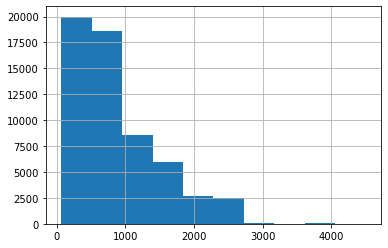

In [106]:
flights.DIST.hist()

In [107]:
# 7.10.2 운행 거리 구간을 bins에 지정한다.
#   pd.cut 함수를 이용해서 flights['DIST']에  구간을 할당한 Series cuts를 생성한다. 
bins = [-np.inf, 200, 500, 1000, 2000, np.inf]
cuts = pd.cut(flights['DIST'], bins=bins)
cuts.head()

0     (500.0, 1000.0]
1    (1000.0, 2000.0]
2     (500.0, 1000.0]
3    (1000.0, 2000.0]
4    (1000.0, 2000.0]
Name: DIST, dtype: category
Categories (5, interval[float64]): [(-inf, 200.0] < (200.0, 500.0] < (500.0, 1000.0] < (1000.0, 2000.0] < (2000.0, inf]]

In [108]:
# 7.10.3 각 구간별 건수를 세어본다. . 500~ 1000 구간이 가장 많다. 
cuts.value_counts()

(500.0, 1000.0]     20659
(200.0, 500.0]      15874
(1000.0, 2000.0]    14186
(2000.0, inf]        4054
(-inf, 200.0]        3719
Name: DIST, dtype: int64

In [109]:
# 7.10.4 cuts를 그룹 컬럼으로 하고 (인덱스가 같으므로 가능하다. )
# 항공사 별로  비율을 구한다. 
flights.groupby(cuts)['AIRLINE'].value_counts(normalize=True)\
    .round(3).head(15)

DIST            AIRLINE
(-inf, 200.0]   OO         0.326
                EV         0.289
                MQ         0.211
                DL         0.086
                AA         0.052
                UA         0.027
                WN         0.009
(200.0, 500.0]  WN         0.194
                DL         0.189
                OO         0.159
                EV         0.156
                MQ         0.100
                AA         0.071
                UA         0.062
                VX         0.028
Name: AIRLINE, dtype: float64

In [182]:
type(flights.groupby(cuts)['AIRLINE'])

pandas.core.groupby.generic.SeriesGroupBy

In [184]:
print([attr for attr in dir(flights.groupby(cuts)['AIRLINE']) if not attr.startswith('_')])

['agg', 'aggregate', 'all', 'any', 'apply', 'backfill', 'bfill', 'corr', 'count', 'cov', 'cumcount', 'cummax', 'cummin', 'cumprod', 'cumsum', 'describe', 'diff', 'dtype', 'expanding', 'ffill', 'fillna', 'filter', 'first', 'get_group', 'groups', 'head', 'hist', 'idxmax', 'idxmin', 'indices', 'is_monotonic_decreasing', 'is_monotonic_increasing', 'last', 'mad', 'max', 'mean', 'median', 'min', 'ndim', 'ngroup', 'ngroups', 'nlargest', 'nsmallest', 'nth', 'nunique', 'ohlc', 'pad', 'pct_change', 'pipe', 'plot', 'prod', 'quantile', 'rank', 'resample', 'rolling', 'sem', 'shift', 'size', 'skew', 'std', 'str', 'sum', 'tail', 'take', 'transform', 'tshift', 'unique', 'value_counts', 'var']


## >>There's more... 7.10

In [110]:
#  각 구간별 비행 시간에 대해서 Median을 구한다. 
flights.groupby(cuts)['AIR_TIME'].quantile().div(60).round(2)

DIST
(-inf, 200.0]       0.50
(200.0, 500.0]      0.92
(500.0, 1000.0]     1.65
(1000.0, 2000.0]    2.93
(2000.0, inf]       4.70
Name: AIR_TIME, dtype: float64

In [111]:
# bins에 label을 지정하고 항공사를 unstack 하여 각 구간별 가장 많은 항공사를 구한다. 
labels=['Under an Hour', '1 Hour', '1-2 Hours', '2-4 Hours', '4+ Hours']
cuts2 = pd.cut(flights['DIST'], bins=bins, labels=labels)
flights.groupby(cuts2)['AIRLINE'].value_counts(normalize=True)\
        .round(3)\
        .unstack()\
        .style.highlight_max(axis=1)

AIRLINE,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
DIST,,,,,,,,,,,,,,
Under an Hour,0.052000,nan,nan,0.086000,0.289000,nan,nan,0.211000,nan,0.326000,0.027000,nan,nan,0.009000
1 Hour,0.071000,0.001000,0.007000,0.189000,0.156000,0.005000,nan,0.100000,0.012000,0.159000,0.062000,0.016000,0.028000,0.194000
1-2 Hours,0.144000,0.023000,0.003000,0.206000,0.101000,0.038000,nan,0.051000,0.030000,0.106000,0.131000,0.025000,0.004000,0.138000
2-4 Hours,0.264000,0.016000,0.003000,0.165000,0.016000,0.031000,nan,0.003000,0.045000,0.046000,0.199000,0.040000,0.012000,0.160000
4+ Hours,0.212000,0.012000,0.080000,0.171000,nan,0.004000,0.028000,nan,0.019000,nan,0.289000,0.065000,0.074000,0.046000


In [186]:
flights.groupby(cuts2)['AIRLINE'].value_counts(normalize=True)\
        .round(3)

DIST           AIRLINE
Under an Hour  OO         0.326
               EV         0.289
               MQ         0.211
               DL         0.086
               AA         0.052
               UA         0.027
               WN         0.009
1 Hour         WN         0.194
               DL         0.189
               OO         0.159
               EV         0.156
               MQ         0.100
               AA         0.071
               UA         0.062
               VX         0.028
               US         0.016
               NK         0.012
               B6         0.007
               F9         0.005
               AS         0.001
1-2 Hours      DL         0.206
               AA         0.144
               WN         0.138
               UA         0.131
               OO         0.106
               EV         0.101
               MQ         0.051
               F9         0.038
               NK         0.030
               US         0.025
               AS

# 7.11 Counting the total number of flights between cities

In [112]:
### [Tech] 출발공항과 도착공항 여부 관계 없이 구간별 항공편 수를 구하기 위해서
#     groupby로 집계한 결과에서 출발/도착 공항을 컬럼방향으로 정렬한다. 
### [Goal] flight에서 두 도시간 운항 항공편수 산출

## >> How to do it...

In [113]:
# 7.11.1  fligths.csv로 부터 flights 를 load 한다 
# 출발공항별 도착공항별 운항편수를 구한다. 
flights = pd.read_csv('data/flights.csv')
flights_ct = flights.groupby(['ORG_AIR','DEST_AIR']).size()
flights_ct.head()

ORG_AIR  DEST_AIR
ATL      ABE         31
         ABQ         16
         ABY         19
         ACY          6
         AEX         40
dtype: int64

In [114]:
# 7.11.2  애틀란타와 휴스턴 공항간 운항편을 선택해본다. 
flights_ct.loc[[('ATL', 'IAH'), ('IAH', 'ATL')]]

ORG_AIR  DEST_AIR
ATL      IAH         121
IAH      ATL         148
dtype: int64

In [115]:
# 7.11.3 (교재 버전 - 작동이 다르게 됨)
flights_sort = flights[['ORG_AIR', 'DEST_AIR']]\
    .apply(sorted, axis=1)
flights_sort.head()

0    [LAX, SLC]
1    [DEN, IAD]
2    [DFW, VPS]
3    [DCA, DFW]
4    [LAX, MCI]
dtype: object

In [116]:
# 7.11.3  (수정본)  출발공항/도착공항을 알파벳순으로 정렬하고 flight_sort에 저장한다. 
flights_sort = flights[['ORG_AIR', 'DEST_AIR']].T\
    .apply(sorted).T
flights_sort.head()

,ORG_AIR,DEST_AIR
0,LAX,SLC
1,DEN,IAD
2,DFW,VPS
3,DCA,DFW
4,LAX,MCI


In [117]:
# 7.11.4  flights_sort에 컬럼명을 AIR1, AIR2로 변경하고 
#  'AIR1', 'AIR2' 로 groupby를 수행하여 건수를 산출한다. 
rename_dict = {'ORG_AIR':'AIR1', 'DEST_AIR':'AIR2'} 
flights_sort = flights_sort.rename(columns = rename_dict) 
flights_sort
flight_ct2 =  flights_sort.groupby(['AIR1', 'AIR2']).size()
flight_ct2

AIR1  AIR2
ABE   ATL      31
      ORD      24
ABI   DFW      74
ABQ   ATL      16
      DEN      46
             ... 
SFO   SNA     122
      STL      20
      SUN      10
      TUS      20
      XNA       2
Length: 1085, dtype: int64

In [118]:
# 7.11.5 애틀란타 휴스턴으로 통합된 값이 확인된다. (121 + 168 = 269 )
flight_ct2.loc[('ATL', 'IAH')]

269

In [119]:
# 7.11.6 휴스턴-애틀란타는  정렬결과 애털란타- 휴스턴으로 통합되었다. 
flight_ct2.loc[('IAH', 'ATL')]

KeyError: ('IAH', 'ATL')

## >> There's more... 7.11

In [120]:
# np.sort를 적용하면 속도 향상을 기대 할 수 있다. 
data_sorted = np.sort(flights[['ORG_AIR', 'DEST_AIR']])
data_sorted[:10]

array([['LAX', 'SLC'],
       ['DEN', 'IAD'],
       ['DFW', 'VPS'],
       ['DCA', 'DFW'],
       ['LAX', 'MCI'],
       ['IAH', 'SAN'],
       ['DFW', 'MSY'],
       ['PHX', 'SFO'],
       ['ORD', 'STL'],
       ['IAH', 'SJC']], dtype=object)

In [121]:
flights_sort2 = pd.DataFrame(data_sorted, columns=['AIR1', 'AIR2'])
fs_orig = flights_sort.rename(columns={'ORG_AIR':'AIR1', \
                                         'DEST_AIR':'AIR2'})
flights_sort2.equals(fs_orig)

True

In [122]:
%timeit flights_sorted = flights[['ORG_AIR', 'DEST_AIR']].apply(sorted, axis=1)

3.94 s ± 392 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
%%timeit
data_sorted = np.sort(flights[['ORG_AIR', 'DEST_AIR']])
flights_sorted2 = pd.DataFrame(data_sorted, columns=['AIR1', 'AIR2'])

10.5 ms ± 967 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 7.12 Finding the longest streak of on-time flights

In [124]:
### [Tech] 동일한 값이 연속되는 길이를  산정하는 로직의 트릭을 살펴본다. 
###      블리언 시리즈, 누적합.cumsum()과  .diff(), .ffill(), .where를 사용
###     for loop 사용 없이 메소드의 연산으로 문제를 해결한다. 
### [Goal] 항공사별 출발공항별 최장 연속 정시 운행 기록을 찾아낸다. 

## >> How to do it...

In [176]:
# 7.12.1  연속된 값의 길이 (1의 길이)를 세어 보기 위해 0과 1로 구성된 Series를 생성한다. 
s = pd.Series([0, 1, 1, 0, 1, 1, 1, 0])
s

0    0
1    1
2    1
3    0
4    1
5    1
6    1
7    0
dtype: int64

In [126]:
# 7.12.2 누적합을 적용  

s1 = s.cumsum()
s1

0    0
1    1
2    2
3    2
4    3
5    4
6    5
7    5
dtype: int64

In [127]:

# 7.12.3 
#  누적합에서 같은 값이 이어지는 부분에서 다시 0부터 counting 할 수 있도록 오프셋 시리즈를 
# 구성해 본다. 

# 오프셋 누적합과 원래 값을 곱한다. (0이 곱해지는 곳은 0이 된다. )
offset = s.mul(s1)
offset

0    0
1    1
2    2
3    0
4    3
5    4
6    5
7    0
dtype: int64

In [128]:
# 7.12.4 .diff()메소드를 적용하면, 바로 앞 행의 값의 차이를 구한다. 
#  0 의 위치는 음의 값을 갖게 된다. 
offset = s.mul(s1).diff()
offset

0    NaN
1    1.0
2    1.0
3   -2.0
4    3.0
5    1.0
6    1.0
7   -5.0
dtype: float64

In [129]:
# 7.12.5  pandas Series의 where 함수는 거짓인 값에 대해서 NaN으로 마스킹한다. 
#  즉 음의 값을 갖지 않는 곳은 NaN으로 마스킹 한다. 
offset = s.mul(s1).diff().where(lambda x: x < 0)
offset

0    NaN
1    NaN
2    NaN
3   -2.0
4    NaN
5    NaN
6    NaN
7   -5.0
dtype: float64

In [130]:
# 7.12.6  NaN 값이 된 곳을 그 앞의 정상값으로 채운다. (.ffill)
offset = s.mul(s1).diff().where(lambda x: x < 0).ffill()
offset

0    NaN
1    NaN
2    NaN
3   -2.0
4   -2.0
5   -2.0
6   -2.0
7   -5.0
dtype: float64

In [131]:
# 7.12.7  누적합에 오프셋을 더한다.  이런 방식을 통해서 참(1)이 연속 되는 개수를 구한다. 
s1.add(offset, fill_value = 0)

0    0.0
1    1.0
2    2.0
3    0.0
4    1.0
5    2.0
6    3.0
7    0.0
dtype: float64

In [132]:
# 7.12.8  fligths.csv로 부터 flights 를 load 한다 
#  도착지연 ARR_DELAY로 부터 정시 비행여부를 판단하는 Boolean Series를 만들고
#  ( 15분 이하 여부) 이를 정수혀으로 만들어 'ON_TIME' 컬럼으로 추가 한다. 
flights = pd.read_csv('data/flights.csv')
flights['ON_TIME'] = flights['ARR_DELAY'].lt(15).astype(int)
flights[['AIRLINE', 'ORG_AIR', 'ON_TIME']].head(10)

,AIRLINE,ORG_AIR,ON_TIME
0,WN,LAX,0
1,UA,DEN,1
2,MQ,DFW,0
3,AA,DFW,1
4,WN,LAX,0
5,UA,IAH,1
6,AA,DFW,0
7,F9,SFO,1
8,AA,ORD,1
9,UA,IAH,1


In [133]:
# 7.12.9  앞서 살펴본 연속된 1의 개수를 구하고  그 중 최대값을 반환하는 max_streak
#   함수를 생성한다. 
def max_streak(s):
    s1 = s.cumsum()
    return s.mul(s1).diff().where(lambda x: x < 0) \
            .ffill().add(s1, fill_value=0).max()

In [134]:
# 7.12.10 연속된 항공 운항 편수를 구해야 하므로 항공사 정보를 
#  월/일자/출발시간 순으로 정렬한다. 
# 여기에 항공사별 출발 공항별로 그룹화 하고, 앞서 생성한 정시여부 ON_TIME 컬럼을 추출하여
# 평균, 대상 항공 편수, 최장 연속 정시 운항 편수를 구한다. (.agg에 집계함수로 전달 한다. )
flights.sort_values(['MONTH', 'DAY', 'SCHED_DEP']) \
       .groupby(['AIRLINE', 'ORG_AIR'])['ON_TIME'] \
       .agg(['mean', 'size', max_streak]).round(2).head()

mean  size  max_streak
AIRLINE ORG_AIR                        
AA      ATL      0.82   233          15
        DEN      0.74   219          17
        DFW      0.78  4006          64
        IAH      0.80   196          24
        LAS      0.79   374          29

## >> There's more... 7.12

In [179]:
# 유사한 개념으로 이번에는 가장 길게 이어진 지연 항공편의 시작일자와 끝 날자를 연속 지연수와 
#  함께 DataFrame으로 반환하는 함수를 작성하고.  groupby 객체에 .apply로 호출해보자.


def max_delay_streak(df):
    df = df.reset_index(drop=True)
    s = 1 - df['ON_TIME']     # 연착 비행의 연속을 구하기 위해 ON_Time의 보수를 구한다. 
    s1 = s.cumsum()
    streak = s.mul(s1).diff().where(lambda x: x < 0) \
              .ffill().add(s1, fill_value=0)
    last_idx = streak.idxmax()     # idxmax 메소드를 이용해서 최대값의 위치를 구한다. 
    
    first_idx = last_idx - streak.max() + 1  # last_idx에서 연속된 항공편을 빼어 첫 위치를 구한다. 
    
    if streak.max() <=0:
        print(last_idx, first_idx, streak.max())
        return None


    df_return = df.loc[[first_idx, last_idx], ['MONTH', 'DAY']] # 반환할 df를 구성
    df_return['streak'] = streak.max()  # 반환할 df에 streak 컬럼 추가 
    
    df_return.index = ['first', 'last']   # 반환할 df에 행 레이블 
    df_return.index.name='streak_row'  # 인덱스의 이름 지정

    return df_return

In [155]:
max_delay_streak(flights)

12.0

In [181]:
# 앞의 7.12.10 과 같이 월/일/출발시간으로 정렬된 df에 항공사별 출발공항별
#  최대 연착 정보를 max_delay_streak를 적용하여 구하고
#   streak를 내림차순으로 정렬하여 최대 지연이 일어났던 기록을 구한다. 
#  아메리칸 에어의 달라스 공항에서 2월 26일에서 3월 1일 까지 38회 연속 연착 기록이 있다.
#  (눈이 내린 것에 기인함. )

flights.sort_values(['MONTH', 'DAY', 'SCHED_DEP']) \
       .groupby(['AIRLINE', 'ORG_AIR']) \
       .apply(max_delay_streak)\
       .sort_values(['streak','MONTH','DAY'], ascending=[False, True, True])

0 1.0 0.0


MONTH  DAY  streak
AIRLINE ORG_AIR streak_row                    
AA      DFW     first           2   26    38.0
                last            3    1    38.0
MQ      ORD     first           1    6    28.0
                last            1   12    28.0
        DFW     first           2   21    25.0
...                           ...  ...     ...
AS      ATL     last            5    4     1.0
        IAH     first           5   25     1.0
                last            5   25     1.0
MQ      IAH     first          12   28     1.0
                last           12   28     1.0

[226 rows x 3 columns]